In [23]:
#independency
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from keras.models import Sequential, Model
from keras.layers import CuDNNLSTM, Dense, Bidirectional, Input, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.engine.topology import Layer
from keras.callbacks import *

In [2]:
max_features = 95000
embed_size = 300
max_len = 70

In [3]:
#데이터 불러오기
train_df = pd.read_csv('C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head(10)

(1306122, 3)
(375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


0    1225312
1      80810
Name: target, dtype: int64


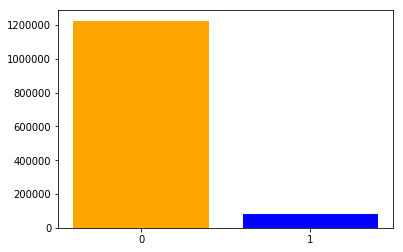

In [3]:
'''
데이터를 눈으로 보았을 때 target의 분포가 한 쪽에 치우쳐저 있는 것 같으므로
이를 눈으로 확인
'''
y = train_df['target'].value_counts()
print(y)
plt.bar(["0","1"],y, color = ['orange', 'blue'])
plt.show()

#문장의 길이
question = train_df['question_text']
number_of_words = []
for i in question:
    number_of_words.append(len(i.split(" ")))
    
print('Max of sentence length is {} '.format(max(number_of_words)))
print('Min of sentence length is {} '.format(min(number_of_words)))
print('Mean of sentence length is {} '.format(np.mean(number_of_words)))

sns.distplot(number_of_words)

In [4]:
#split
train_df, val_df = train_test_split(train_df, test_size = 0.1)

In [4]:
#임베딩을 위한 pretrained_vector 불러오기
embeddings_glove = {}
f = open('C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt', 'r', encoding = 'utf-8')

for line in f:
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_glove[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_glove))

Found 2196016 word vectors.


In [4]:
#임베딩을 위한 pretrained_vector 불러오기
embeddings_para = {}
f = open('C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt', 'r', encoding = 'utf-8', errors = 'ignore')

for line in f:
    if len(line) > 100:
        values = line.split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_para[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_para))

Found 1703755 word vectors.


In [5]:
#pickle파일로 저장하기(glove)
output_path = 'C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/pickle'

out_file = output_path + "/embeddings_glove.pickle"
with open(out_file, 'wb') as f:
    pickle.dump(embeddings_glove, f)

In [ ]:
#pickle파일로 저장하기(para)
output_path = 'C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/pickle'

out_file = output_path + "/embeddings_para.pickle"
with open(out_file, 'wb') as f:
    pickle.dump(embeddings_para, f)

In [5]:
#pickle 파일불러오기(glove)
output_path = 'C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/pickle'
out_file_glove = output_path + "/embeddings_glove.pickle"

with open(out_file_glove, 'rb') as f1:
    embeddings_glove = pickle.load(f1)

In [6]:
#pickle 파일불러오기(para)
output_path = 'C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/pickle'
out_file_para = output_path + "/embeddings_para.pickle"

with open(out_file_para, 'rb') as f2:
    embeddings_para = pickle.load(f2)

In [59]:
#두개의 pre-trained embedding을 이용하여 train word의 embedding 찾기
#1.train_df 에서 unique한 단어들을 가져올 것(word_index 이용)
train_x = train_df['question_text']
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(train_x)
train_x = tokenizer.texts_to_sequences(train_x)
word_index = tokenizer.word_index

nb_words = len(word_index)

In [61]:
#2.그 unique한 단어들과 pre-trained embedding을 비교해서 embedding 찾기(정규화 작업 필요)
#glove
glove_embs = np.stack(embeddings_glove.values())
glove_emb_mean, glove_emb_std = glove_embs.mean(), glove_embs.std()
glove_emb_size = glove_embs.shape[1]

glove_dict = {}
emb_matrix_glove = np.random.normal(glove_emb_mean, glove_emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    word_vector = embeddings_glove.get(word)
    if i >= nb_words:
        continue
    if word_vector is not None:
        glove_dict.update({word: word_vector})
    else:
        glove_dict.update({word : emb_matrix_glove[0]})
        
#para
para_embs = np.stack(embeddings_para.values())
para_emb_mean, para_emb_std = para_embs.mean(), para_embs.std()
para_emb_size = para_embs.shape[1]

para_dict = {}
emb_matrix_para = np.random.normal(para_emb_mean, para_emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    word_vector = embeddings_para.get(word)
    if i >= nb_words:
        continue
    if word_vector is not None:
        para_dict.update({word: word_vector})
    else:
        para_dict.update({word : emb_matrix_para[0]})

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [93]:
#두 pre-trained의 average를 이용
embedding_matrix = {}

for word, glove_emb in glove_dict.items():
    para_emb = para_dict.get(word)
    embedding_matrix.update({word : np.mean([glove_emb, para_emb], axis = 0)})

In [97]:
#pickle파일로 저장하기(embedding_matrix)
output_path = 'C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/pickle'

out_file = output_path + "/embedding_matrix.pickle"
with open(out_file, 'wb') as f:
    pickle.dump(embedding_matrix, f)

In [6]:
#pickle 파일 불러오기(embedding_matrix)
output_path = 'C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/pickle'
out_file_matrix = output_path + "/embedding_matrix.pickle"

with open(out_file_matrix, 'rb') as f1:
    embedding_matrix = pickle.load(f1)

In [7]:
#이미 임베딩된 모델을 이용해서 train_data의 embedding_vector를 구한다.
def text_to_array(text):
    empyt_emb = np.zeros(300)
    text = text[:-1].split()[:30]
    embeds = [embedding_matrix.get(x, empyt_emb) for x in text]
    embeds+= [empyt_emb] * (30 - len(embeds))
    return np.array(embeds)

# train_vects = [text_to_array(X_text) for X_text in tqdm(train_df["question_text"])]
val_vects = np.array([text_to_array(X_text) for X_text in tqdm(val_df["question_text"][:3000])])
val_y = np.array(val_df["target"][:3000])

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 6056.39it/s]


In [30]:
#data provider
batch_size = 128

def batch_gen(train_df):
    n_batches = math.ceil(len(train_df) / batch_size)
    #shuffle train data
    while True:
        train_df = train_df.sample(frac = 1.)
        for i in range(n_batches):
            texts = train_df.iloc[i*batch_size : (i+1)*batch_size, 1] #train을 batch_size만큼 잘라줌
            text_arr = np.array([text_to_array(text) for text in texts]) #mini batch의 data를 vector로 바꿔줌
            yield text_arr, np.array(train_df['target'][i*batch_size : (i+1)*batch_size]) #text vector와 label 동시에 뱉어줌    

## Training(Bidirectional LSTM + Attention Layer)

In [31]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [32]:
def model_lstm_atten():
    
    inp= Input(shape = (30,300))
    x = Bidirectional(CuDNNLSTM(64, return_sequences = True))(inp)
    y = Bidirectional(CuDNNLSTM(64, return_sequences = True))(x)
    
    atten_1 = Attention(30)(x) #skip connect
    atten_2 = Attention(30)(y)
    avg_pool = GlobalAveragePooling1D()(y)
    max_pool = GlobalMaxPooling1D()(y)
    
    conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
    outp = Dense(1, activation = 'sigmoid')(conc)
    
    model = Model(inputs = inp, outputs = outp)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=[f1])
    
    return model

## Cyclic Learning Rate

In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [34]:
#훈련
epoch_size = 20
steps_per_epoch = 1000
clr = CyclicLR(base_lr=0.001, max_lr=0.002,
               step_size=300., mode='exp_range',
               gamma=0.99994)

mg = batch_gen(train_df)
model = model_lstm_atten()

model.fit_generator(mg, 
                    epochs = epoch_size, 
                    steps_per_epoch = steps_per_epoch,
                    validation_data = (val_vects, val_y),
                    verbose = True,
                    callbacks=[clr])

Epoch 1/20
   2/1000 [..............................] - ETA: 18:10 - loss: 0.7186 - f1: 0.097 - ETA: 10:50 - loss: 0.6677 - f1: 0.0488

C:\Users\ASUS\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106009). Check your callbacks.
  % delta_t_median)


 432/1000 [===========>..................] - ETA: 5:42 - loss: 0.5963 - f1: 0.024 - ETA: 3:57 - loss: 0.5312 - f1: 0.01 - ETA: 3:04 - loss: 0.4773 - f1: 0.01 - ETA: 2:32 - loss: 0.4475 - f1: 0.00 - ETA: 2:11 - loss: 0.4261 - f1: 0.00 - ETA: 1:56 - loss: 0.3960 - f1: 0.00 - ETA: 1:45 - loss: 0.3759 - f1: 0.00 - ETA: 1:36 - loss: 0.3555 - f1: 0.00 - ETA: 1:29 - loss: 0.3455 - f1: 0.00 - ETA: 1:23 - loss: 0.3401 - f1: 0.00 - ETA: 1:18 - loss: 0.3317 - f1: 0.00 - ETA: 1:14 - loss: 0.3251 - f1: 0.00 - ETA: 1:10 - loss: 0.3154 - f1: 0.00 - ETA: 1:07 - loss: 0.3071 - f1: 0.00 - ETA: 1:04 - loss: 0.3033 - f1: 0.00 - ETA: 1:02 - loss: 0.2976 - f1: 0.00 - ETA: 1:00 - loss: 0.2958 - f1: 0.00 - ETA: 58s - loss: 0.2934 - f1: 0.0026 - ETA: 57s - loss: 0.2935 - f1: 0.002 - ETA: 55s - loss: 0.2905 - f1: 0.002 - ETA: 54s - loss: 0.2851 - f1: 0.002 - ETA: 52s - loss: 0.2821 - f1: 0.002 - ETA: 51s - loss: 0.2772 - f1: 0.002 - ETA: 50s - loss: 0.2744 - f1: 0.002 - ETA: 49s - loss: 0.2707 - f1: 0.001 - ETA

 872/1000 [=========================>....] - ETA: 17s - loss: 0.1707 - f1: 0.248 - ETA: 17s - loss: 0.1709 - f1: 0.248 - ETA: 17s - loss: 0.1707 - f1: 0.249 - ETA: 17s - loss: 0.1705 - f1: 0.249 - ETA: 17s - loss: 0.1702 - f1: 0.249 - ETA: 17s - loss: 0.1699 - f1: 0.248 - ETA: 17s - loss: 0.1698 - f1: 0.248 - ETA: 17s - loss: 0.1697 - f1: 0.249 - ETA: 16s - loss: 0.1695 - f1: 0.248 - ETA: 16s - loss: 0.1695 - f1: 0.249 - ETA: 16s - loss: 0.1692 - f1: 0.251 - ETA: 16s - loss: 0.1690 - f1: 0.251 - ETA: 16s - loss: 0.1688 - f1: 0.253 - ETA: 16s - loss: 0.1689 - f1: 0.253 - ETA: 16s - loss: 0.1687 - f1: 0.254 - ETA: 16s - loss: 0.1686 - f1: 0.255 - ETA: 16s - loss: 0.1686 - f1: 0.256 - ETA: 16s - loss: 0.1686 - f1: 0.256 - ETA: 16s - loss: 0.1684 - f1: 0.256 - ETA: 16s - loss: 0.1683 - f1: 0.256 - ETA: 16s - loss: 0.1680 - f1: 0.257 - ETA: 16s - loss: 0.1681 - f1: 0.257 - ETA: 16s - loss: 0.1679 - f1: 0.257 - ETA: 15s - loss: 0.1678 - f1: 0.257 - ETA: 15s - loss: 0.1677 - f1: 0.256 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1561 - f1: 0.30 - ETA: 3s - loss: 0.1559 - f1: 0.30 - ETA: 3s - loss: 0.1560 - f1: 0.30 - ETA: 3s - loss: 0.1560 - f1: 0.30 - ETA: 3s - loss: 0.1560 - f1: 0.30 - ETA: 3s - loss: 0.1559 - f1: 0.31 - ETA: 3s - loss: 0.1559 - f1: 0.31 - ETA: 3s - loss: 0.1558 - f1: 0.31 - ETA: 3s - loss: 0.1558 - f1: 0.31 - ETA: 3s - loss: 0.1557 - f1: 0.31 - ETA: 3s - loss: 0.1557 - f1: 0.31 - ETA: 3s - loss: 0.1558 - f1: 0.31 - ETA: 2s - loss: 0.1558 - f1: 0.31 - ETA: 2s - loss: 0.1560 - f1: 0.31 - ETA: 2s - loss: 0.1559 - f1: 0.31 - ETA: 2s - loss: 0.1559 - f1: 0.31 - ETA: 2s - loss: 0.1558 - f1: 0.31 - ETA: 2s - loss: 0.1557 - f1: 0.31 - ETA: 2s - loss: 0.1557 - f1: 0.31 - ETA: 2s - loss: 0.1557 - f1: 0.31 - ETA: 2s - loss: 0.1558 - f1: 0.31 - ETA: 2s - loss: 0.1558 - f1: 0.31 - ETA: 2s - loss: 0.1557 - f1: 0.31 - ETA: 2s - loss: 0.1556 - f1: 0.31 - ETA: 2s - loss: 0.1556 - f1: 0.31 - ETA: 2s - loss: 0.1557 - f1: 0.31 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 24s - loss: 0.1812 - f1: 0.181 - ETA: 27s - loss: 0.1591 - f1: 0.322 - ETA: 27s - loss: 0.1473 - f1: 0.353 - ETA: 27s - loss: 0.1467 - f1: 0.377 - ETA: 27s - loss: 0.1441 - f1: 0.350 - ETA: 26s - loss: 0.1416 - f1: 0.359 - ETA: 26s - loss: 0.1380 - f1: 0.358 - ETA: 26s - loss: 0.1408 - f1: 0.364 - ETA: 26s - loss: 0.1378 - f1: 0.381 - ETA: 26s - loss: 0.1423 - f1: 0.375 - ETA: 27s - loss: 0.1424 - f1: 0.348 - ETA: 26s - loss: 0.1461 - f1: 0.344 - ETA: 26s - loss: 0.1448 - f1: 0.351 - ETA: 26s - loss: 0.1461 - f1: 0.361 - ETA: 26s - loss: 0.1451 - f1: 0.364 - ETA: 26s - loss: 0.1450 - f1: 0.346 - ETA: 26s - loss: 0.1458 - f1: 0.358 - ETA: 26s - loss: 0.1451 - f1: 0.349 - ETA: 26s - loss: 0.1455 - f1: 0.357 - ETA: 26s - loss: 0.1458 - f1: 0.359 - ETA: 26s - loss: 0.1446 - f1: 0.363 - ETA: 26s - loss: 0.1430 - f1: 0.377 - ETA: 26s - loss: 0.1427 - f1: 0.388 - ETA: 26s - loss: 0.1411 - f1: 0.379 - ETA: 26s - loss: 0.1403 - f1: 0.381 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1351 - f1: 0.395 - ETA: 15s - loss: 0.1349 - f1: 0.396 - ETA: 15s - loss: 0.1348 - f1: 0.396 - ETA: 15s - loss: 0.1348 - f1: 0.396 - ETA: 15s - loss: 0.1348 - f1: 0.395 - ETA: 15s - loss: 0.1347 - f1: 0.395 - ETA: 15s - loss: 0.1347 - f1: 0.394 - ETA: 15s - loss: 0.1347 - f1: 0.396 - ETA: 15s - loss: 0.1348 - f1: 0.396 - ETA: 15s - loss: 0.1349 - f1: 0.397 - ETA: 15s - loss: 0.1349 - f1: 0.398 - ETA: 14s - loss: 0.1350 - f1: 0.398 - ETA: 14s - loss: 0.1350 - f1: 0.398 - ETA: 14s - loss: 0.1349 - f1: 0.398 - ETA: 14s - loss: 0.1352 - f1: 0.397 - ETA: 14s - loss: 0.1352 - f1: 0.397 - ETA: 14s - loss: 0.1350 - f1: 0.397 - ETA: 14s - loss: 0.1350 - f1: 0.398 - ETA: 14s - loss: 0.1350 - f1: 0.398 - ETA: 14s - loss: 0.1351 - f1: 0.399 - ETA: 14s - loss: 0.1350 - f1: 0.400 - ETA: 14s - loss: 0.1352 - f1: 0.400 - ETA: 14s - loss: 0.1355 - f1: 0.400 - ETA: 14s - loss: 0.1353 - f1: 0.400 - ETA: 14s - loss: 0.1353 - f1: 0.399 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1338 - f1: 0.41 - ETA: 3s - loss: 0.1338 - f1: 0.41 - ETA: 3s - loss: 0.1338 - f1: 0.41 - ETA: 3s - loss: 0.1337 - f1: 0.41 - ETA: 3s - loss: 0.1338 - f1: 0.41 - ETA: 3s - loss: 0.1338 - f1: 0.41 - ETA: 3s - loss: 0.1339 - f1: 0.41 - ETA: 3s - loss: 0.1340 - f1: 0.41 - ETA: 3s - loss: 0.1340 - f1: 0.41 - ETA: 2s - loss: 0.1339 - f1: 0.41 - ETA: 2s - loss: 0.1339 - f1: 0.41 - ETA: 2s - loss: 0.1339 - f1: 0.41 - ETA: 2s - loss: 0.1339 - f1: 0.41 - ETA: 2s - loss: 0.1338 - f1: 0.41 - ETA: 2s - loss: 0.1338 - f1: 0.41 - ETA: 2s - loss: 0.1338 - f1: 0.41 - ETA: 2s - loss: 0.1338 - f1: 0.41 - ETA: 2s - loss: 0.1338 - f1: 0.41 - ETA: 2s - loss: 0.1339 - f1: 0.41 - ETA: 2s - loss: 0.1338 - f1: 0.41 - ETA: 2s - loss: 0.1339 - f1: 0.41 - ETA: 2s - loss: 0.1339 - f1: 0.42 - ETA: 2s - loss: 0.1339 - f1: 0.42 - ETA: 2s - loss: 0.1340 - f1: 0.42 - ETA: 2s - loss: 0.1339 - f1: 0.41 - ETA: 2s - loss: 0.1339 - f1: 0.42 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 25s - loss: 0.0790 - f1: 0.250 - ETA: 26s - loss: 0.0997 - f1: 0.412 - ETA: 27s - loss: 0.1106 - f1: 0.375 - ETA: 27s - loss: 0.1155 - f1: 0.405 - ETA: 27s - loss: 0.1219 - f1: 0.339 - ETA: 26s - loss: 0.1361 - f1: 0.326 - ETA: 26s - loss: 0.1390 - f1: 0.335 - ETA: 26s - loss: 0.1374 - f1: 0.379 - ETA: 26s - loss: 0.1346 - f1: 0.411 - ETA: 26s - loss: 0.1406 - f1: 0.419 - ETA: 26s - loss: 0.1399 - f1: 0.434 - ETA: 26s - loss: 0.1393 - f1: 0.431 - ETA: 26s - loss: 0.1411 - f1: 0.422 - ETA: 26s - loss: 0.1425 - f1: 0.410 - ETA: 26s - loss: 0.1428 - f1: 0.403 - ETA: 26s - loss: 0.1419 - f1: 0.406 - ETA: 26s - loss: 0.1410 - f1: 0.413 - ETA: 26s - loss: 0.1403 - f1: 0.424 - ETA: 26s - loss: 0.1405 - f1: 0.433 - ETA: 26s - loss: 0.1384 - f1: 0.428 - ETA: 26s - loss: 0.1380 - f1: 0.425 - ETA: 26s - loss: 0.1380 - f1: 0.422 - ETA: 26s - loss: 0.1376 - f1: 0.425 - ETA: 26s - loss: 0.1362 - f1: 0.434 - ETA: 26s - loss: 0.1349 - f1: 0.439 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1296 - f1: 0.442 - ETA: 15s - loss: 0.1296 - f1: 0.442 - ETA: 15s - loss: 0.1297 - f1: 0.442 - ETA: 15s - loss: 0.1297 - f1: 0.441 - ETA: 15s - loss: 0.1296 - f1: 0.442 - ETA: 15s - loss: 0.1294 - f1: 0.443 - ETA: 15s - loss: 0.1295 - f1: 0.442 - ETA: 15s - loss: 0.1295 - f1: 0.442 - ETA: 15s - loss: 0.1294 - f1: 0.442 - ETA: 15s - loss: 0.1293 - f1: 0.443 - ETA: 15s - loss: 0.1291 - f1: 0.443 - ETA: 15s - loss: 0.1290 - f1: 0.444 - ETA: 15s - loss: 0.1291 - f1: 0.444 - ETA: 14s - loss: 0.1292 - f1: 0.444 - ETA: 14s - loss: 0.1291 - f1: 0.444 - ETA: 14s - loss: 0.1291 - f1: 0.444 - ETA: 14s - loss: 0.1293 - f1: 0.443 - ETA: 14s - loss: 0.1294 - f1: 0.443 - ETA: 14s - loss: 0.1293 - f1: 0.443 - ETA: 14s - loss: 0.1293 - f1: 0.443 - ETA: 14s - loss: 0.1292 - f1: 0.443 - ETA: 14s - loss: 0.1296 - f1: 0.443 - ETA: 14s - loss: 0.1295 - f1: 0.443 - ETA: 14s - loss: 0.1295 - f1: 0.444 - ETA: 14s - loss: 0.1295 - f1: 0.444 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1307 - f1: 0.46 - ETA: 3s - loss: 0.1307 - f1: 0.46 - ETA: 3s - loss: 0.1307 - f1: 0.46 - ETA: 3s - loss: 0.1307 - f1: 0.46 - ETA: 3s - loss: 0.1306 - f1: 0.46 - ETA: 3s - loss: 0.1306 - f1: 0.46 - ETA: 3s - loss: 0.1306 - f1: 0.46 - ETA: 3s - loss: 0.1304 - f1: 0.46 - ETA: 3s - loss: 0.1305 - f1: 0.46 - ETA: 2s - loss: 0.1305 - f1: 0.46 - ETA: 2s - loss: 0.1305 - f1: 0.46 - ETA: 2s - loss: 0.1306 - f1: 0.46 - ETA: 2s - loss: 0.1307 - f1: 0.46 - ETA: 2s - loss: 0.1308 - f1: 0.46 - ETA: 2s - loss: 0.1307 - f1: 0.46 - ETA: 2s - loss: 0.1307 - f1: 0.46 - ETA: 2s - loss: 0.1307 - f1: 0.46 - ETA: 2s - loss: 0.1307 - f1: 0.46 - ETA: 2s - loss: 0.1308 - f1: 0.46 - ETA: 2s - loss: 0.1309 - f1: 0.46 - ETA: 2s - loss: 0.1310 - f1: 0.46 - ETA: 2s - loss: 0.1309 - f1: 0.46 - ETA: 2s - loss: 0.1308 - f1: 0.46 - ETA: 2s - loss: 0.1308 - f1: 0.46 - ETA: 2s - loss: 0.1308 - f1: 0.46 - ETA: 2s - loss: 0.1307 - f1: 0.46 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 25s - loss: 0.2494 - f1: 0.428 - ETA: 27s - loss: 0.1538 - f1: 0.324 - ETA: 27s - loss: 0.1314 - f1: 0.437 - ETA: 27s - loss: 0.1329 - f1: 0.452 - ETA: 27s - loss: 0.1373 - f1: 0.474 - ETA: 26s - loss: 0.1390 - f1: 0.432 - ETA: 26s - loss: 0.1402 - f1: 0.450 - ETA: 26s - loss: 0.1386 - f1: 0.473 - ETA: 26s - loss: 0.1342 - f1: 0.480 - ETA: 26s - loss: 0.1331 - f1: 0.489 - ETA: 26s - loss: 0.1310 - f1: 0.498 - ETA: 26s - loss: 0.1339 - f1: 0.497 - ETA: 26s - loss: 0.1350 - f1: 0.486 - ETA: 26s - loss: 0.1354 - f1: 0.479 - ETA: 26s - loss: 0.1325 - f1: 0.485 - ETA: 26s - loss: 0.1344 - f1: 0.481 - ETA: 26s - loss: 0.1347 - f1: 0.477 - ETA: 26s - loss: 0.1339 - f1: 0.482 - ETA: 26s - loss: 0.1337 - f1: 0.486 - ETA: 26s - loss: 0.1352 - f1: 0.470 - ETA: 26s - loss: 0.1333 - f1: 0.462 - ETA: 26s - loss: 0.1345 - f1: 0.458 - ETA: 26s - loss: 0.1333 - f1: 0.462 - ETA: 26s - loss: 0.1329 - f1: 0.460 - ETA: 26s - loss: 0.1329 - f1: 0.458 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1274 - f1: 0.461 - ETA: 15s - loss: 0.1272 - f1: 0.461 - ETA: 15s - loss: 0.1270 - f1: 0.462 - ETA: 15s - loss: 0.1271 - f1: 0.462 - ETA: 15s - loss: 0.1272 - f1: 0.461 - ETA: 15s - loss: 0.1270 - f1: 0.461 - ETA: 15s - loss: 0.1269 - f1: 0.461 - ETA: 15s - loss: 0.1270 - f1: 0.461 - ETA: 15s - loss: 0.1272 - f1: 0.461 - ETA: 15s - loss: 0.1274 - f1: 0.461 - ETA: 15s - loss: 0.1273 - f1: 0.462 - ETA: 15s - loss: 0.1272 - f1: 0.462 - ETA: 14s - loss: 0.1272 - f1: 0.463 - ETA: 14s - loss: 0.1270 - f1: 0.463 - ETA: 14s - loss: 0.1269 - f1: 0.464 - ETA: 14s - loss: 0.1270 - f1: 0.464 - ETA: 14s - loss: 0.1270 - f1: 0.464 - ETA: 14s - loss: 0.1271 - f1: 0.463 - ETA: 14s - loss: 0.1272 - f1: 0.462 - ETA: 14s - loss: 0.1270 - f1: 0.461 - ETA: 14s - loss: 0.1271 - f1: 0.461 - ETA: 14s - loss: 0.1273 - f1: 0.461 - ETA: 14s - loss: 0.1271 - f1: 0.461 - ETA: 14s - loss: 0.1272 - f1: 0.461 - ETA: 14s - loss: 0.1272 - f1: 0.461 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1264 - f1: 0.47 - ETA: 3s - loss: 0.1264 - f1: 0.47 - ETA: 3s - loss: 0.1265 - f1: 0.47 - ETA: 3s - loss: 0.1265 - f1: 0.47 - ETA: 3s - loss: 0.1265 - f1: 0.47 - ETA: 3s - loss: 0.1265 - f1: 0.47 - ETA: 3s - loss: 0.1267 - f1: 0.47 - ETA: 3s - loss: 0.1266 - f1: 0.47 - ETA: 3s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1264 - f1: 0.47 - ETA: 2s - loss: 0.1264 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1264 - f1: 0.47 - ETA: 2s - loss: 0.1264 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1267 - f1: 0.47 - ETA: 2s - loss: 0.1266 - f1: 0.47 - ETA: 2s - loss: 0.1265 - f1: 0.47 - ETA: 2s - loss: 0.1266 - f1: 0.47 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 25s - loss: 0.1657 - f1: 0.461 - ETA: 27s - loss: 0.1706 - f1: 0.456 - ETA: 27s - loss: 0.1942 - f1: 0.424 - ETA: 27s - loss: 0.1787 - f1: 0.445 - ETA: 27s - loss: 0.1714 - f1: 0.460 - ETA: 27s - loss: 0.1673 - f1: 0.468 - ETA: 26s - loss: 0.1573 - f1: 0.503 - ETA: 26s - loss: 0.1526 - f1: 0.485 - ETA: 27s - loss: 0.1535 - f1: 0.471 - ETA: 26s - loss: 0.1522 - f1: 0.461 - ETA: 26s - loss: 0.1490 - f1: 0.482 - ETA: 26s - loss: 0.1463 - f1: 0.490 - ETA: 26s - loss: 0.1431 - f1: 0.492 - ETA: 26s - loss: 0.1426 - f1: 0.495 - ETA: 26s - loss: 0.1431 - f1: 0.497 - ETA: 26s - loss: 0.1409 - f1: 0.500 - ETA: 26s - loss: 0.1400 - f1: 0.503 - ETA: 26s - loss: 0.1379 - f1: 0.520 - ETA: 26s - loss: 0.1358 - f1: 0.522 - ETA: 26s - loss: 0.1348 - f1: 0.522 - ETA: 26s - loss: 0.1345 - f1: 0.526 - ETA: 26s - loss: 0.1341 - f1: 0.522 - ETA: 26s - loss: 0.1351 - f1: 0.507 - ETA: 26s - loss: 0.1350 - f1: 0.508 - ETA: 26s - loss: 0.1343 - f1: 0.505 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1289 - f1: 0.482 - ETA: 15s - loss: 0.1290 - f1: 0.481 - ETA: 15s - loss: 0.1289 - f1: 0.482 - ETA: 15s - loss: 0.1289 - f1: 0.482 - ETA: 15s - loss: 0.1290 - f1: 0.482 - ETA: 15s - loss: 0.1291 - f1: 0.483 - ETA: 15s - loss: 0.1290 - f1: 0.483 - ETA: 15s - loss: 0.1291 - f1: 0.483 - ETA: 15s - loss: 0.1291 - f1: 0.483 - ETA: 15s - loss: 0.1292 - f1: 0.483 - ETA: 15s - loss: 0.1291 - f1: 0.482 - ETA: 15s - loss: 0.1289 - f1: 0.481 - ETA: 14s - loss: 0.1288 - f1: 0.482 - ETA: 14s - loss: 0.1288 - f1: 0.481 - ETA: 14s - loss: 0.1288 - f1: 0.480 - ETA: 14s - loss: 0.1286 - f1: 0.480 - ETA: 14s - loss: 0.1287 - f1: 0.480 - ETA: 14s - loss: 0.1287 - f1: 0.480 - ETA: 14s - loss: 0.1285 - f1: 0.480 - ETA: 14s - loss: 0.1284 - f1: 0.480 - ETA: 14s - loss: 0.1286 - f1: 0.480 - ETA: 14s - loss: 0.1284 - f1: 0.480 - ETA: 14s - loss: 0.1285 - f1: 0.480 - ETA: 14s - loss: 0.1284 - f1: 0.480 - ETA: 14s - loss: 0.1284 - f1: 0.481 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1255 - f1: 0.48 - ETA: 3s - loss: 0.1254 - f1: 0.48 - ETA: 3s - loss: 0.1253 - f1: 0.48 - ETA: 3s - loss: 0.1252 - f1: 0.48 - ETA: 3s - loss: 0.1251 - f1: 0.48 - ETA: 3s - loss: 0.1252 - f1: 0.48 - ETA: 3s - loss: 0.1252 - f1: 0.48 - ETA: 3s - loss: 0.1253 - f1: 0.48 - ETA: 3s - loss: 0.1253 - f1: 0.48 - ETA: 3s - loss: 0.1253 - f1: 0.48 - ETA: 2s - loss: 0.1254 - f1: 0.48 - ETA: 2s - loss: 0.1255 - f1: 0.48 - ETA: 2s - loss: 0.1255 - f1: 0.48 - ETA: 2s - loss: 0.1256 - f1: 0.48 - ETA: 2s - loss: 0.1256 - f1: 0.48 - ETA: 2s - loss: 0.1256 - f1: 0.48 - ETA: 2s - loss: 0.1256 - f1: 0.48 - ETA: 2s - loss: 0.1256 - f1: 0.48 - ETA: 2s - loss: 0.1255 - f1: 0.48 - ETA: 2s - loss: 0.1256 - f1: 0.48 - ETA: 2s - loss: 0.1257 - f1: 0.48 - ETA: 2s - loss: 0.1257 - f1: 0.48 - ETA: 2s - loss: 0.1257 - f1: 0.48 - ETA: 2s - loss: 0.1257 - f1: 0.48 - ETA: 2s - loss: 0.1256 - f1: 0.48 - ETA: 2s - loss: 0.1257 - f1: 0.48 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 25s - loss: 0.1290 - f1: 0.428 - ETA: 27s - loss: 0.1622 - f1: 0.494 - ETA: 27s - loss: 0.1488 - f1: 0.570 - ETA: 27s - loss: 0.1364 - f1: 0.596 - ETA: 27s - loss: 0.1281 - f1: 0.629 - ETA: 27s - loss: 0.1209 - f1: 0.567 - ETA: 26s - loss: 0.1186 - f1: 0.555 - ETA: 26s - loss: 0.1123 - f1: 0.554 - ETA: 26s - loss: 0.1115 - f1: 0.545 - ETA: 26s - loss: 0.1120 - f1: 0.541 - ETA: 26s - loss: 0.1120 - f1: 0.533 - ETA: 26s - loss: 0.1156 - f1: 0.532 - ETA: 26s - loss: 0.1184 - f1: 0.521 - ETA: 26s - loss: 0.1171 - f1: 0.527 - ETA: 26s - loss: 0.1173 - f1: 0.532 - ETA: 26s - loss: 0.1161 - f1: 0.526 - ETA: 26s - loss: 0.1171 - f1: 0.520 - ETA: 26s - loss: 0.1188 - f1: 0.527 - ETA: 26s - loss: 0.1198 - f1: 0.525 - ETA: 26s - loss: 0.1194 - f1: 0.520 - ETA: 26s - loss: 0.1208 - f1: 0.526 - ETA: 26s - loss: 0.1212 - f1: 0.530 - ETA: 26s - loss: 0.1206 - f1: 0.530 - ETA: 26s - loss: 0.1204 - f1: 0.533 - ETA: 26s - loss: 0.1204 - f1: 0.531 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1236 - f1: 0.509 - ETA: 15s - loss: 0.1238 - f1: 0.508 - ETA: 15s - loss: 0.1238 - f1: 0.509 - ETA: 15s - loss: 0.1236 - f1: 0.509 - ETA: 15s - loss: 0.1234 - f1: 0.509 - ETA: 15s - loss: 0.1236 - f1: 0.510 - ETA: 15s - loss: 0.1234 - f1: 0.510 - ETA: 15s - loss: 0.1233 - f1: 0.510 - ETA: 15s - loss: 0.1232 - f1: 0.510 - ETA: 15s - loss: 0.1232 - f1: 0.510 - ETA: 15s - loss: 0.1232 - f1: 0.510 - ETA: 15s - loss: 0.1229 - f1: 0.511 - ETA: 15s - loss: 0.1230 - f1: 0.511 - ETA: 14s - loss: 0.1228 - f1: 0.512 - ETA: 14s - loss: 0.1225 - f1: 0.513 - ETA: 14s - loss: 0.1225 - f1: 0.513 - ETA: 14s - loss: 0.1223 - f1: 0.513 - ETA: 14s - loss: 0.1224 - f1: 0.514 - ETA: 14s - loss: 0.1223 - f1: 0.514 - ETA: 14s - loss: 0.1221 - f1: 0.515 - ETA: 14s - loss: 0.1222 - f1: 0.515 - ETA: 14s - loss: 0.1221 - f1: 0.515 - ETA: 14s - loss: 0.1222 - f1: 0.515 - ETA: 14s - loss: 0.1221 - f1: 0.515 - ETA: 14s - loss: 0.1222 - f1: 0.515 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1243 - f1: 0.50 - ETA: 3s - loss: 0.1243 - f1: 0.50 - ETA: 3s - loss: 0.1244 - f1: 0.50 - ETA: 3s - loss: 0.1244 - f1: 0.50 - ETA: 3s - loss: 0.1244 - f1: 0.50 - ETA: 3s - loss: 0.1244 - f1: 0.50 - ETA: 3s - loss: 0.1245 - f1: 0.50 - ETA: 3s - loss: 0.1244 - f1: 0.50 - ETA: 3s - loss: 0.1244 - f1: 0.50 - ETA: 3s - loss: 0.1244 - f1: 0.50 - ETA: 2s - loss: 0.1244 - f1: 0.50 - ETA: 2s - loss: 0.1243 - f1: 0.50 - ETA: 2s - loss: 0.1243 - f1: 0.50 - ETA: 2s - loss: 0.1242 - f1: 0.50 - ETA: 2s - loss: 0.1242 - f1: 0.50 - ETA: 2s - loss: 0.1242 - f1: 0.50 - ETA: 2s - loss: 0.1242 - f1: 0.50 - ETA: 2s - loss: 0.1241 - f1: 0.50 - ETA: 2s - loss: 0.1241 - f1: 0.50 - ETA: 2s - loss: 0.1241 - f1: 0.50 - ETA: 2s - loss: 0.1240 - f1: 0.50 - ETA: 2s - loss: 0.1240 - f1: 0.50 - ETA: 2s - loss: 0.1239 - f1: 0.50 - ETA: 2s - loss: 0.1239 - f1: 0.50 - ETA: 2s - loss: 0.1239 - f1: 0.50 - ETA: 2s - loss: 0.1239 - f1: 0.50 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 24s - loss: 0.1415 - f1: 0.307 - ETA: 26s - loss: 0.1437 - f1: 0.303 - ETA: 26s - loss: 0.1454 - f1: 0.371 - ETA: 26s - loss: 0.1365 - f1: 0.455 - ETA: 27s - loss: 0.1348 - f1: 0.492 - ETA: 26s - loss: 0.1266 - f1: 0.453 - ETA: 26s - loss: 0.1255 - f1: 0.468 - ETA: 26s - loss: 0.1221 - f1: 0.460 - ETA: 26s - loss: 0.1192 - f1: 0.482 - ETA: 26s - loss: 0.1167 - f1: 0.468 - ETA: 26s - loss: 0.1202 - f1: 0.477 - ETA: 26s - loss: 0.1180 - f1: 0.469 - ETA: 26s - loss: 0.1186 - f1: 0.477 - ETA: 26s - loss: 0.1191 - f1: 0.467 - ETA: 26s - loss: 0.1169 - f1: 0.478 - ETA: 26s - loss: 0.1179 - f1: 0.466 - ETA: 26s - loss: 0.1191 - f1: 0.471 - ETA: 26s - loss: 0.1193 - f1: 0.473 - ETA: 26s - loss: 0.1201 - f1: 0.465 - ETA: 26s - loss: 0.1197 - f1: 0.460 - ETA: 26s - loss: 0.1197 - f1: 0.459 - ETA: 26s - loss: 0.1197 - f1: 0.456 - ETA: 26s - loss: 0.1182 - f1: 0.472 - ETA: 26s - loss: 0.1183 - f1: 0.467 - ETA: 26s - loss: 0.1200 - f1: 0.468 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1223 - f1: 0.508 - ETA: 15s - loss: 0.1225 - f1: 0.508 - ETA: 15s - loss: 0.1225 - f1: 0.508 - ETA: 15s - loss: 0.1225 - f1: 0.508 - ETA: 15s - loss: 0.1225 - f1: 0.508 - ETA: 15s - loss: 0.1224 - f1: 0.509 - ETA: 15s - loss: 0.1222 - f1: 0.510 - ETA: 15s - loss: 0.1222 - f1: 0.510 - ETA: 15s - loss: 0.1221 - f1: 0.510 - ETA: 15s - loss: 0.1222 - f1: 0.510 - ETA: 15s - loss: 0.1220 - f1: 0.511 - ETA: 15s - loss: 0.1221 - f1: 0.511 - ETA: 15s - loss: 0.1222 - f1: 0.511 - ETA: 15s - loss: 0.1221 - f1: 0.510 - ETA: 14s - loss: 0.1221 - f1: 0.511 - ETA: 14s - loss: 0.1223 - f1: 0.510 - ETA: 14s - loss: 0.1222 - f1: 0.509 - ETA: 14s - loss: 0.1223 - f1: 0.509 - ETA: 14s - loss: 0.1223 - f1: 0.508 - ETA: 14s - loss: 0.1222 - f1: 0.508 - ETA: 14s - loss: 0.1224 - f1: 0.508 - ETA: 14s - loss: 0.1224 - f1: 0.509 - ETA: 14s - loss: 0.1226 - f1: 0.508 - ETA: 14s - loss: 0.1227 - f1: 0.509 - ETA: 14s - loss: 0.1227 - f1: 0.509 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1223 - f1: 0.51 - ETA: 3s - loss: 0.1223 - f1: 0.51 - ETA: 3s - loss: 0.1223 - f1: 0.51 - ETA: 3s - loss: 0.1222 - f1: 0.51 - ETA: 3s - loss: 0.1222 - f1: 0.51 - ETA: 3s - loss: 0.1222 - f1: 0.51 - ETA: 3s - loss: 0.1222 - f1: 0.51 - ETA: 3s - loss: 0.1221 - f1: 0.51 - ETA: 3s - loss: 0.1220 - f1: 0.51 - ETA: 3s - loss: 0.1220 - f1: 0.51 - ETA: 2s - loss: 0.1219 - f1: 0.51 - ETA: 2s - loss: 0.1220 - f1: 0.51 - ETA: 2s - loss: 0.1219 - f1: 0.51 - ETA: 2s - loss: 0.1219 - f1: 0.51 - ETA: 2s - loss: 0.1219 - f1: 0.51 - ETA: 2s - loss: 0.1220 - f1: 0.51 - ETA: 2s - loss: 0.1220 - f1: 0.51 - ETA: 2s - loss: 0.1220 - f1: 0.51 - ETA: 2s - loss: 0.1221 - f1: 0.51 - ETA: 2s - loss: 0.1222 - f1: 0.51 - ETA: 2s - loss: 0.1222 - f1: 0.51 - ETA: 2s - loss: 0.1222 - f1: 0.51 - ETA: 2s - loss: 0.1222 - f1: 0.51 - ETA: 2s - loss: 0.1222 - f1: 0.51 - ETA: 2s - loss: 0.1223 - f1: 0.51 - ETA: 2s - loss: 0.1223 - f1: 0.51 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 25s - loss: 0.2008 - f1: 0.363 - ETA: 26s - loss: 0.1461 - f1: 0.432 - ETA: 26s - loss: 0.1302 - f1: 0.416 - ETA: 26s - loss: 0.1192 - f1: 0.456 - ETA: 26s - loss: 0.1193 - f1: 0.500 - ETA: 26s - loss: 0.1151 - f1: 0.500 - ETA: 26s - loss: 0.1164 - f1: 0.511 - ETA: 26s - loss: 0.1153 - f1: 0.521 - ETA: 26s - loss: 0.1150 - f1: 0.511 - ETA: 26s - loss: 0.1216 - f1: 0.507 - ETA: 26s - loss: 0.1194 - f1: 0.508 - ETA: 26s - loss: 0.1175 - f1: 0.526 - ETA: 26s - loss: 0.1164 - f1: 0.527 - ETA: 26s - loss: 0.1212 - f1: 0.518 - ETA: 26s - loss: 0.1222 - f1: 0.515 - ETA: 26s - loss: 0.1221 - f1: 0.526 - ETA: 26s - loss: 0.1235 - f1: 0.523 - ETA: 26s - loss: 0.1208 - f1: 0.522 - ETA: 26s - loss: 0.1194 - f1: 0.531 - ETA: 26s - loss: 0.1187 - f1: 0.518 - ETA: 26s - loss: 0.1188 - f1: 0.520 - ETA: 26s - loss: 0.1190 - f1: 0.520 - ETA: 26s - loss: 0.1198 - f1: 0.521 - ETA: 26s - loss: 0.1187 - f1: 0.523 - ETA: 26s - loss: 0.1194 - f1: 0.522 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1207 - f1: 0.517 - ETA: 15s - loss: 0.1207 - f1: 0.516 - ETA: 15s - loss: 0.1205 - f1: 0.517 - ETA: 15s - loss: 0.1205 - f1: 0.517 - ETA: 15s - loss: 0.1204 - f1: 0.518 - ETA: 15s - loss: 0.1203 - f1: 0.519 - ETA: 15s - loss: 0.1203 - f1: 0.519 - ETA: 15s - loss: 0.1202 - f1: 0.518 - ETA: 15s - loss: 0.1201 - f1: 0.518 - ETA: 15s - loss: 0.1199 - f1: 0.519 - ETA: 15s - loss: 0.1197 - f1: 0.519 - ETA: 15s - loss: 0.1196 - f1: 0.519 - ETA: 15s - loss: 0.1197 - f1: 0.520 - ETA: 15s - loss: 0.1197 - f1: 0.520 - ETA: 14s - loss: 0.1198 - f1: 0.520 - ETA: 14s - loss: 0.1199 - f1: 0.520 - ETA: 14s - loss: 0.1200 - f1: 0.520 - ETA: 14s - loss: 0.1199 - f1: 0.520 - ETA: 14s - loss: 0.1200 - f1: 0.520 - ETA: 14s - loss: 0.1200 - f1: 0.520 - ETA: 14s - loss: 0.1200 - f1: 0.520 - ETA: 14s - loss: 0.1201 - f1: 0.521 - ETA: 14s - loss: 0.1202 - f1: 0.521 - ETA: 14s - loss: 0.1203 - f1: 0.521 - ETA: 14s - loss: 0.1205 - f1: 0.520 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1201 - f1: 0.51 - ETA: 3s - loss: 0.1200 - f1: 0.51 - ETA: 3s - loss: 0.1200 - f1: 0.51 - ETA: 3s - loss: 0.1201 - f1: 0.51 - ETA: 3s - loss: 0.1201 - f1: 0.51 - ETA: 3s - loss: 0.1202 - f1: 0.51 - ETA: 3s - loss: 0.1202 - f1: 0.51 - ETA: 3s - loss: 0.1203 - f1: 0.51 - ETA: 3s - loss: 0.1202 - f1: 0.51 - ETA: 3s - loss: 0.1202 - f1: 0.51 - ETA: 2s - loss: 0.1201 - f1: 0.51 - ETA: 2s - loss: 0.1201 - f1: 0.51 - ETA: 2s - loss: 0.1201 - f1: 0.51 - ETA: 2s - loss: 0.1201 - f1: 0.51 - ETA: 2s - loss: 0.1200 - f1: 0.51 - ETA: 2s - loss: 0.1200 - f1: 0.51 - ETA: 2s - loss: 0.1199 - f1: 0.51 - ETA: 2s - loss: 0.1200 - f1: 0.51 - ETA: 2s - loss: 0.1200 - f1: 0.51 - ETA: 2s - loss: 0.1199 - f1: 0.51 - ETA: 2s - loss: 0.1199 - f1: 0.51 - ETA: 2s - loss: 0.1200 - f1: 0.51 - ETA: 2s - loss: 0.1199 - f1: 0.51 - ETA: 2s - loss: 0.1199 - f1: 0.51 - ETA: 2s - loss: 0.1199 - f1: 0.51 - ETA: 2s - loss: 0.1199 - f1: 0.51 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 25s - loss: 0.1240 - f1: 0.500 - ETA: 26s - loss: 0.1312 - f1: 0.542 - ETA: 27s - loss: 0.1258 - f1: 0.561 - ETA: 27s - loss: 0.1306 - f1: 0.565 - ETA: 27s - loss: 0.1272 - f1: 0.566 - ETA: 26s - loss: 0.1231 - f1: 0.579 - ETA: 26s - loss: 0.1193 - f1: 0.593 - ETA: 26s - loss: 0.1189 - f1: 0.567 - ETA: 26s - loss: 0.1181 - f1: 0.576 - ETA: 26s - loss: 0.1191 - f1: 0.566 - ETA: 26s - loss: 0.1225 - f1: 0.576 - ETA: 26s - loss: 0.1203 - f1: 0.577 - ETA: 26s - loss: 0.1170 - f1: 0.577 - ETA: 26s - loss: 0.1149 - f1: 0.587 - ETA: 26s - loss: 0.1162 - f1: 0.581 - ETA: 26s - loss: 0.1177 - f1: 0.566 - ETA: 26s - loss: 0.1174 - f1: 0.572 - ETA: 26s - loss: 0.1184 - f1: 0.581 - ETA: 26s - loss: 0.1194 - f1: 0.573 - ETA: 26s - loss: 0.1176 - f1: 0.577 - ETA: 26s - loss: 0.1173 - f1: 0.571 - ETA: 26s - loss: 0.1148 - f1: 0.578 - ETA: 26s - loss: 0.1170 - f1: 0.568 - ETA: 26s - loss: 0.1196 - f1: 0.563 - ETA: 26s - loss: 0.1191 - f1: 0.566 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1195 - f1: 0.515 - ETA: 15s - loss: 0.1196 - f1: 0.515 - ETA: 15s - loss: 0.1196 - f1: 0.514 - ETA: 15s - loss: 0.1196 - f1: 0.514 - ETA: 15s - loss: 0.1196 - f1: 0.514 - ETA: 15s - loss: 0.1196 - f1: 0.514 - ETA: 15s - loss: 0.1196 - f1: 0.515 - ETA: 15s - loss: 0.1195 - f1: 0.515 - ETA: 15s - loss: 0.1196 - f1: 0.514 - ETA: 15s - loss: 0.1197 - f1: 0.514 - ETA: 15s - loss: 0.1198 - f1: 0.513 - ETA: 15s - loss: 0.1200 - f1: 0.513 - ETA: 15s - loss: 0.1201 - f1: 0.512 - ETA: 15s - loss: 0.1200 - f1: 0.512 - ETA: 14s - loss: 0.1200 - f1: 0.513 - ETA: 14s - loss: 0.1200 - f1: 0.514 - ETA: 14s - loss: 0.1200 - f1: 0.514 - ETA: 14s - loss: 0.1199 - f1: 0.513 - ETA: 14s - loss: 0.1198 - f1: 0.514 - ETA: 14s - loss: 0.1197 - f1: 0.515 - ETA: 14s - loss: 0.1195 - f1: 0.515 - ETA: 14s - loss: 0.1195 - f1: 0.516 - ETA: 14s - loss: 0.1197 - f1: 0.516 - ETA: 14s - loss: 0.1195 - f1: 0.516 - ETA: 14s - loss: 0.1195 - f1: 0.516 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1193 - f1: 0.50 - ETA: 3s - loss: 0.1192 - f1: 0.50 - ETA: 3s - loss: 0.1192 - f1: 0.50 - ETA: 3s - loss: 0.1191 - f1: 0.50 - ETA: 3s - loss: 0.1191 - f1: 0.50 - ETA: 3s - loss: 0.1192 - f1: 0.50 - ETA: 3s - loss: 0.1192 - f1: 0.50 - ETA: 3s - loss: 0.1191 - f1: 0.50 - ETA: 3s - loss: 0.1191 - f1: 0.50 - ETA: 3s - loss: 0.1191 - f1: 0.50 - ETA: 2s - loss: 0.1191 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1191 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1192 - f1: 0.50 - ETA: 2s - loss: 0.1

 426/1000 [===========>..................] - ETA: 26s - loss: 0.1302 - f1: 0.545 - ETA: 28s - loss: 0.1121 - f1: 0.581 - ETA: 27s - loss: 0.1238 - f1: 0.565 - ETA: 27s - loss: 0.1164 - f1: 0.515 - ETA: 27s - loss: 0.1230 - f1: 0.521 - ETA: 27s - loss: 0.1219 - f1: 0.529 - ETA: 27s - loss: 0.1285 - f1: 0.529 - ETA: 26s - loss: 0.1260 - f1: 0.527 - ETA: 26s - loss: 0.1222 - f1: 0.541 - ETA: 26s - loss: 0.1278 - f1: 0.518 - ETA: 26s - loss: 0.1266 - f1: 0.530 - ETA: 26s - loss: 0.1254 - f1: 0.543 - ETA: 26s - loss: 0.1281 - f1: 0.537 - ETA: 26s - loss: 0.1279 - f1: 0.532 - ETA: 26s - loss: 0.1273 - f1: 0.516 - ETA: 26s - loss: 0.1287 - f1: 0.490 - ETA: 26s - loss: 0.1267 - f1: 0.496 - ETA: 26s - loss: 0.1263 - f1: 0.497 - ETA: 26s - loss: 0.1241 - f1: 0.509 - ETA: 26s - loss: 0.1248 - f1: 0.510 - ETA: 26s - loss: 0.1232 - f1: 0.504 - ETA: 26s - loss: 0.1239 - f1: 0.499 - ETA: 26s - loss: 0.1226 - f1: 0.505 - ETA: 26s - loss: 0.1229 - f1: 0.512 - ETA: 26s - loss: 0.1222 - f1: 0.515 - ETA: 

 868/1000 [=========================>....] - ETA: 16s - loss: 0.1204 - f1: 0.528 - ETA: 16s - loss: 0.1201 - f1: 0.529 - ETA: 16s - loss: 0.1201 - f1: 0.529 - ETA: 16s - loss: 0.1201 - f1: 0.529 - ETA: 16s - loss: 0.1200 - f1: 0.529 - ETA: 16s - loss: 0.1199 - f1: 0.529 - ETA: 16s - loss: 0.1202 - f1: 0.529 - ETA: 15s - loss: 0.1200 - f1: 0.530 - ETA: 15s - loss: 0.1200 - f1: 0.529 - ETA: 15s - loss: 0.1199 - f1: 0.529 - ETA: 15s - loss: 0.1199 - f1: 0.529 - ETA: 15s - loss: 0.1198 - f1: 0.528 - ETA: 15s - loss: 0.1197 - f1: 0.529 - ETA: 15s - loss: 0.1198 - f1: 0.530 - ETA: 15s - loss: 0.1198 - f1: 0.529 - ETA: 15s - loss: 0.1195 - f1: 0.529 - ETA: 15s - loss: 0.1194 - f1: 0.530 - ETA: 15s - loss: 0.1196 - f1: 0.530 - ETA: 15s - loss: 0.1194 - f1: 0.530 - ETA: 15s - loss: 0.1193 - f1: 0.530 - ETA: 15s - loss: 0.1193 - f1: 0.530 - ETA: 15s - loss: 0.1192 - f1: 0.530 - ETA: 15s - loss: 0.1190 - f1: 0.530 - ETA: 15s - loss: 0.1192 - f1: 0.531 - ETA: 14s - loss: 0.1190 - f1: 0.531 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1152 - f1: 0.53 - ETA: 3s - loss: 0.1152 - f1: 0.53 - ETA: 3s - loss: 0.1152 - f1: 0.54 - ETA: 3s - loss: 0.1152 - f1: 0.54 - ETA: 3s - loss: 0.1152 - f1: 0.54 - ETA: 3s - loss: 0.1153 - f1: 0.54 - ETA: 3s - loss: 0.1152 - f1: 0.53 - ETA: 3s - loss: 0.1151 - f1: 0.54 - ETA: 3s - loss: 0.1151 - f1: 0.54 - ETA: 3s - loss: 0.1151 - f1: 0.54 - ETA: 3s - loss: 0.1150 - f1: 0.54 - ETA: 3s - loss: 0.1150 - f1: 0.53 - ETA: 3s - loss: 0.1150 - f1: 0.53 - ETA: 2s - loss: 0.1150 - f1: 0.53 - ETA: 2s - loss: 0.1150 - f1: 0.53 - ETA: 2s - loss: 0.1149 - f1: 0.53 - ETA: 2s - loss: 0.1149 - f1: 0.53 - ETA: 2s - loss: 0.1149 - f1: 0.53 - ETA: 2s - loss: 0.1148 - f1: 0.53 - ETA: 2s - loss: 0.1148 - f1: 0.53 - ETA: 2s - loss: 0.1148 - f1: 0.54 - ETA: 2s - loss: 0.1147 - f1: 0.54 - ETA: 2s - loss: 0.1147 - f1: 0.54 - ETA: 2s - loss: 0.1148 - f1: 0.54 - ETA: 2s - loss: 0.1149 - f1: 0.53 - ETA: 2s - loss: 0.1148 - f1: 0.53 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 24s - loss: 0.0838 - f1: 0.769 - ETA: 25s - loss: 0.0647 - f1: 0.832 - ETA: 25s - loss: 0.0952 - f1: 0.762 - ETA: 26s - loss: 0.1022 - f1: 0.686 - ETA: 26s - loss: 0.0997 - f1: 0.657 - ETA: 26s - loss: 0.0946 - f1: 0.626 - ETA: 26s - loss: 0.0974 - f1: 0.636 - ETA: 26s - loss: 0.0991 - f1: 0.648 - ETA: 27s - loss: 0.0985 - f1: 0.648 - ETA: 27s - loss: 0.0998 - f1: 0.645 - ETA: 27s - loss: 0.1013 - f1: 0.617 - ETA: 27s - loss: 0.0996 - f1: 0.616 - ETA: 27s - loss: 0.0994 - f1: 0.612 - ETA: 26s - loss: 0.1031 - f1: 0.600 - ETA: 26s - loss: 0.1060 - f1: 0.596 - ETA: 26s - loss: 0.1058 - f1: 0.592 - ETA: 26s - loss: 0.1041 - f1: 0.594 - ETA: 26s - loss: 0.1064 - f1: 0.585 - ETA: 26s - loss: 0.1103 - f1: 0.578 - ETA: 26s - loss: 0.1089 - f1: 0.584 - ETA: 26s - loss: 0.1089 - f1: 0.583 - ETA: 26s - loss: 0.1095 - f1: 0.576 - ETA: 26s - loss: 0.1102 - f1: 0.577 - ETA: 26s - loss: 0.1091 - f1: 0.576 - ETA: 26s - loss: 0.1080 - f1: 0.579 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1135 - f1: 0.544 - ETA: 15s - loss: 0.1135 - f1: 0.543 - ETA: 15s - loss: 0.1136 - f1: 0.543 - ETA: 15s - loss: 0.1136 - f1: 0.543 - ETA: 15s - loss: 0.1138 - f1: 0.543 - ETA: 15s - loss: 0.1139 - f1: 0.543 - ETA: 15s - loss: 0.1139 - f1: 0.544 - ETA: 15s - loss: 0.1138 - f1: 0.544 - ETA: 15s - loss: 0.1136 - f1: 0.544 - ETA: 15s - loss: 0.1136 - f1: 0.543 - ETA: 15s - loss: 0.1138 - f1: 0.543 - ETA: 15s - loss: 0.1138 - f1: 0.541 - ETA: 15s - loss: 0.1140 - f1: 0.542 - ETA: 15s - loss: 0.1140 - f1: 0.540 - ETA: 15s - loss: 0.1140 - f1: 0.541 - ETA: 15s - loss: 0.1141 - f1: 0.540 - ETA: 15s - loss: 0.1139 - f1: 0.540 - ETA: 14s - loss: 0.1139 - f1: 0.540 - ETA: 14s - loss: 0.1139 - f1: 0.540 - ETA: 14s - loss: 0.1140 - f1: 0.540 - ETA: 14s - loss: 0.1142 - f1: 0.541 - ETA: 14s - loss: 0.1142 - f1: 0.540 - ETA: 14s - loss: 0.1141 - f1: 0.540 - ETA: 14s - loss: 0.1140 - f1: 0.540 - ETA: 14s - loss: 0.1140 - f1: 0.539 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1151 - f1: 0.54 - ETA: 3s - loss: 0.1151 - f1: 0.54 - ETA: 3s - loss: 0.1150 - f1: 0.54 - ETA: 3s - loss: 0.1150 - f1: 0.54 - ETA: 3s - loss: 0.1150 - f1: 0.54 - ETA: 3s - loss: 0.1151 - f1: 0.54 - ETA: 3s - loss: 0.1151 - f1: 0.54 - ETA: 3s - loss: 0.1151 - f1: 0.54 - ETA: 3s - loss: 0.1152 - f1: 0.54 - ETA: 3s - loss: 0.1152 - f1: 0.54 - ETA: 2s - loss: 0.1152 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1152 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1154 - f1: 0.54 - ETA: 2s - loss: 0.1153 - f1: 0.54 - ETA: 2s - loss: 0.1154 - f1: 0.54 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 24s - loss: 0.0801 - f1: 0.666 - ETA: 26s - loss: 0.1078 - f1: 0.588 - ETA: 26s - loss: 0.1107 - f1: 0.633 - ETA: 27s - loss: 0.1124 - f1: 0.572 - ETA: 27s - loss: 0.1048 - f1: 0.543 - ETA: 27s - loss: 0.1013 - f1: 0.544 - ETA: 27s - loss: 0.1028 - f1: 0.541 - ETA: 27s - loss: 0.1025 - f1: 0.540 - ETA: 27s - loss: 0.1058 - f1: 0.555 - ETA: 27s - loss: 0.1077 - f1: 0.562 - ETA: 27s - loss: 0.1049 - f1: 0.564 - ETA: 27s - loss: 0.1043 - f1: 0.570 - ETA: 26s - loss: 0.1064 - f1: 0.581 - ETA: 26s - loss: 0.1087 - f1: 0.570 - ETA: 26s - loss: 0.1071 - f1: 0.577 - ETA: 26s - loss: 0.1073 - f1: 0.577 - ETA: 26s - loss: 0.1107 - f1: 0.574 - ETA: 26s - loss: 0.1101 - f1: 0.581 - ETA: 26s - loss: 0.1107 - f1: 0.580 - ETA: 26s - loss: 0.1121 - f1: 0.587 - ETA: 26s - loss: 0.1116 - f1: 0.587 - ETA: 26s - loss: 0.1110 - f1: 0.576 - ETA: 26s - loss: 0.1102 - f1: 0.570 - ETA: 26s - loss: 0.1084 - f1: 0.567 - ETA: 26s - loss: 0.1101 - f1: 0.558 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1129 - f1: 0.541 - ETA: 15s - loss: 0.1129 - f1: 0.541 - ETA: 15s - loss: 0.1131 - f1: 0.542 - ETA: 15s - loss: 0.1131 - f1: 0.542 - ETA: 15s - loss: 0.1131 - f1: 0.542 - ETA: 15s - loss: 0.1130 - f1: 0.542 - ETA: 15s - loss: 0.1132 - f1: 0.541 - ETA: 15s - loss: 0.1135 - f1: 0.540 - ETA: 15s - loss: 0.1133 - f1: 0.540 - ETA: 15s - loss: 0.1135 - f1: 0.541 - ETA: 15s - loss: 0.1134 - f1: 0.540 - ETA: 15s - loss: 0.1135 - f1: 0.540 - ETA: 15s - loss: 0.1134 - f1: 0.540 - ETA: 15s - loss: 0.1134 - f1: 0.540 - ETA: 14s - loss: 0.1134 - f1: 0.540 - ETA: 14s - loss: 0.1133 - f1: 0.540 - ETA: 14s - loss: 0.1133 - f1: 0.540 - ETA: 14s - loss: 0.1135 - f1: 0.540 - ETA: 14s - loss: 0.1134 - f1: 0.540 - ETA: 14s - loss: 0.1133 - f1: 0.540 - ETA: 14s - loss: 0.1134 - f1: 0.541 - ETA: 14s - loss: 0.1133 - f1: 0.541 - ETA: 14s - loss: 0.1133 - f1: 0.541 - ETA: 14s - loss: 0.1133 - f1: 0.541 - ETA: 14s - loss: 0.1132 - f1: 0.542 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1143 - f1: 0.54 - ETA: 3s - loss: 0.1144 - f1: 0.54 - ETA: 3s - loss: 0.1144 - f1: 0.54 - ETA: 3s - loss: 0.1145 - f1: 0.54 - ETA: 3s - loss: 0.1145 - f1: 0.54 - ETA: 3s - loss: 0.1145 - f1: 0.54 - ETA: 3s - loss: 0.1145 - f1: 0.54 - ETA: 3s - loss: 0.1145 - f1: 0.54 - ETA: 3s - loss: 0.1146 - f1: 0.54 - ETA: 3s - loss: 0.1146 - f1: 0.54 - ETA: 2s - loss: 0.1146 - f1: 0.54 - ETA: 2s - loss: 0.1145 - f1: 0.54 - ETA: 2s - loss: 0.1146 - f1: 0.54 - ETA: 2s - loss: 0.1146 - f1: 0.54 - ETA: 2s - loss: 0.1146 - f1: 0.54 - ETA: 2s - loss: 0.1146 - f1: 0.54 - ETA: 2s - loss: 0.1147 - f1: 0.54 - ETA: 2s - loss: 0.1147 - f1: 0.54 - ETA: 2s - loss: 0.1148 - f1: 0.54 - ETA: 2s - loss: 0.1149 - f1: 0.54 - ETA: 2s - loss: 0.1149 - f1: 0.54 - ETA: 2s - loss: 0.1149 - f1: 0.54 - ETA: 2s - loss: 0.1150 - f1: 0.54 - ETA: 2s - loss: 0.1150 - f1: 0.54 - ETA: 2s - loss: 0.1151 - f1: 0.54 - ETA: 2s - loss: 0.1152 - f1: 0.54 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 25s - loss: 0.1743 - f1: 0.700 - ETA: 27s - loss: 0.1394 - f1: 0.550 - ETA: 27s - loss: 0.1339 - f1: 0.499 - ETA: 27s - loss: 0.1463 - f1: 0.461 - ETA: 27s - loss: 0.1435 - f1: 0.445 - ETA: 27s - loss: 0.1341 - f1: 0.491 - ETA: 27s - loss: 0.1333 - f1: 0.490 - ETA: 27s - loss: 0.1288 - f1: 0.488 - ETA: 27s - loss: 0.1232 - f1: 0.470 - ETA: 27s - loss: 0.1262 - f1: 0.458 - ETA: 27s - loss: 0.1223 - f1: 0.478 - ETA: 27s - loss: 0.1267 - f1: 0.479 - ETA: 27s - loss: 0.1296 - f1: 0.483 - ETA: 26s - loss: 0.1271 - f1: 0.498 - ETA: 26s - loss: 0.1254 - f1: 0.499 - ETA: 26s - loss: 0.1245 - f1: 0.495 - ETA: 26s - loss: 0.1247 - f1: 0.503 - ETA: 26s - loss: 0.1227 - f1: 0.516 - ETA: 26s - loss: 0.1220 - f1: 0.513 - ETA: 26s - loss: 0.1208 - f1: 0.515 - ETA: 26s - loss: 0.1197 - f1: 0.516 - ETA: 26s - loss: 0.1198 - f1: 0.519 - ETA: 26s - loss: 0.1200 - f1: 0.527 - ETA: 26s - loss: 0.1181 - f1: 0.532 - ETA: 26s - loss: 0.1183 - f1: 0.536 - ETA: 

 871/1000 [=========================>....] - ETA: 15s - loss: 0.1160 - f1: 0.553 - ETA: 15s - loss: 0.1159 - f1: 0.551 - ETA: 15s - loss: 0.1160 - f1: 0.552 - ETA: 15s - loss: 0.1159 - f1: 0.552 - ETA: 15s - loss: 0.1158 - f1: 0.553 - ETA: 15s - loss: 0.1158 - f1: 0.552 - ETA: 15s - loss: 0.1158 - f1: 0.551 - ETA: 15s - loss: 0.1159 - f1: 0.550 - ETA: 15s - loss: 0.1158 - f1: 0.551 - ETA: 15s - loss: 0.1159 - f1: 0.550 - ETA: 15s - loss: 0.1158 - f1: 0.550 - ETA: 15s - loss: 0.1156 - f1: 0.551 - ETA: 15s - loss: 0.1157 - f1: 0.550 - ETA: 15s - loss: 0.1155 - f1: 0.551 - ETA: 14s - loss: 0.1155 - f1: 0.551 - ETA: 14s - loss: 0.1154 - f1: 0.551 - ETA: 14s - loss: 0.1154 - f1: 0.551 - ETA: 14s - loss: 0.1154 - f1: 0.551 - ETA: 14s - loss: 0.1155 - f1: 0.551 - ETA: 14s - loss: 0.1155 - f1: 0.552 - ETA: 14s - loss: 0.1154 - f1: 0.552 - ETA: 14s - loss: 0.1153 - f1: 0.553 - ETA: 14s - loss: 0.1153 - f1: 0.553 - ETA: 14s - loss: 0.1152 - f1: 0.554 - ETA: 14s - loss: 0.1153 - f1: 0.553 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1154 - f1: 0.56 - ETA: 3s - loss: 0.1153 - f1: 0.56 - ETA: 3s - loss: 0.1152 - f1: 0.56 - ETA: 3s - loss: 0.1151 - f1: 0.56 - ETA: 3s - loss: 0.1152 - f1: 0.56 - ETA: 3s - loss: 0.1152 - f1: 0.56 - ETA: 3s - loss: 0.1153 - f1: 0.56 - ETA: 3s - loss: 0.1153 - f1: 0.56 - ETA: 3s - loss: 0.1153 - f1: 0.56 - ETA: 3s - loss: 0.1153 - f1: 0.56 - ETA: 2s - loss: 0.1153 - f1: 0.56 - ETA: 2s - loss: 0.1153 - f1: 0.56 - ETA: 2s - loss: 0.1153 - f1: 0.56 - ETA: 2s - loss: 0.1153 - f1: 0.55 - ETA: 2s - loss: 0.1153 - f1: 0.55 - ETA: 2s - loss: 0.1154 - f1: 0.56 - ETA: 2s - loss: 0.1155 - f1: 0.55 - ETA: 2s - loss: 0.1155 - f1: 0.55 - ETA: 2s - loss: 0.1156 - f1: 0.55 - ETA: 2s - loss: 0.1156 - f1: 0.55 - ETA: 2s - loss: 0.1155 - f1: 0.55 - ETA: 2s - loss: 0.1155 - f1: 0.55 - ETA: 2s - loss: 0.1155 - f1: 0.55 - ETA: 2s - loss: 0.1154 - f1: 0.55 - ETA: 2s - loss: 0.1155 - f1: 0.55 - ETA: 2s - loss: 0.1155 - f1: 0.55 - ETA: 2s - loss: 0.1

 429/1000 [===========>..................] - ETA: 26s - loss: 0.1685 - f1: 0.533 - ETA: 28s - loss: 0.1231 - f1: 0.479 - ETA: 28s - loss: 0.1222 - f1: 0.417 - ETA: 27s - loss: 0.1051 - f1: 0.465 - ETA: 27s - loss: 0.1088 - f1: 0.482 - ETA: 27s - loss: 0.1052 - f1: 0.516 - ETA: 27s - loss: 0.1064 - f1: 0.524 - ETA: 27s - loss: 0.1076 - f1: 0.521 - ETA: 27s - loss: 0.1088 - f1: 0.515 - ETA: 27s - loss: 0.1077 - f1: 0.530 - ETA: 27s - loss: 0.1059 - f1: 0.553 - ETA: 27s - loss: 0.1054 - f1: 0.548 - ETA: 27s - loss: 0.1044 - f1: 0.555 - ETA: 27s - loss: 0.1063 - f1: 0.551 - ETA: 27s - loss: 0.1055 - f1: 0.552 - ETA: 27s - loss: 0.1083 - f1: 0.542 - ETA: 27s - loss: 0.1097 - f1: 0.538 - ETA: 27s - loss: 0.1077 - f1: 0.549 - ETA: 27s - loss: 0.1080 - f1: 0.553 - ETA: 27s - loss: 0.1093 - f1: 0.552 - ETA: 27s - loss: 0.1100 - f1: 0.551 - ETA: 27s - loss: 0.1104 - f1: 0.554 - ETA: 27s - loss: 0.1088 - f1: 0.557 - ETA: 27s - loss: 0.1094 - f1: 0.560 - ETA: 27s - loss: 0.1085 - f1: 0.561 - ETA: 

 871/1000 [=========================>....] - ETA: 16s - loss: 0.1166 - f1: 0.544 - ETA: 16s - loss: 0.1165 - f1: 0.544 - ETA: 15s - loss: 0.1165 - f1: 0.545 - ETA: 15s - loss: 0.1165 - f1: 0.544 - ETA: 15s - loss: 0.1164 - f1: 0.544 - ETA: 15s - loss: 0.1164 - f1: 0.542 - ETA: 15s - loss: 0.1164 - f1: 0.543 - ETA: 15s - loss: 0.1164 - f1: 0.543 - ETA: 15s - loss: 0.1162 - f1: 0.543 - ETA: 15s - loss: 0.1162 - f1: 0.543 - ETA: 15s - loss: 0.1162 - f1: 0.542 - ETA: 15s - loss: 0.1162 - f1: 0.542 - ETA: 15s - loss: 0.1162 - f1: 0.543 - ETA: 15s - loss: 0.1161 - f1: 0.542 - ETA: 15s - loss: 0.1159 - f1: 0.542 - ETA: 15s - loss: 0.1156 - f1: 0.543 - ETA: 15s - loss: 0.1155 - f1: 0.544 - ETA: 15s - loss: 0.1154 - f1: 0.544 - ETA: 15s - loss: 0.1154 - f1: 0.544 - ETA: 15s - loss: 0.1154 - f1: 0.544 - ETA: 14s - loss: 0.1153 - f1: 0.545 - ETA: 14s - loss: 0.1152 - f1: 0.545 - ETA: 14s - loss: 0.1152 - f1: 0.545 - ETA: 14s - loss: 0.1152 - f1: 0.546 - ETA: 14s - loss: 0.1152 - f1: 0.547 - ETA: 

1000/1000 [==============================] - ETA: 3s - loss: 0.1148 - f1: 0.55 - ETA: 3s - loss: 0.1147 - f1: 0.55 - ETA: 3s - loss: 0.1148 - f1: 0.55 - ETA: 3s - loss: 0.1148 - f1: 0.55 - ETA: 3s - loss: 0.1148 - f1: 0.55 - ETA: 3s - loss: 0.1148 - f1: 0.55 - ETA: 3s - loss: 0.1149 - f1: 0.55 - ETA: 3s - loss: 0.1148 - f1: 0.55 - ETA: 3s - loss: 0.1147 - f1: 0.55 - ETA: 3s - loss: 0.1147 - f1: 0.55 - ETA: 3s - loss: 0.1147 - f1: 0.55 - ETA: 2s - loss: 0.1148 - f1: 0.55 - ETA: 2s - loss: 0.1148 - f1: 0.55 - ETA: 2s - loss: 0.1149 - f1: 0.55 - ETA: 2s - loss: 0.1148 - f1: 0.55 - ETA: 2s - loss: 0.1149 - f1: 0.55 - ETA: 2s - loss: 0.1149 - f1: 0.55 - ETA: 2s - loss: 0.1149 - f1: 0.55 - ETA: 2s - loss: 0.1149 - f1: 0.55 - ETA: 2s - loss: 0.1149 - f1: 0.55 - ETA: 2s - loss: 0.1149 - f1: 0.55 - ETA: 2s - loss: 0.1150 - f1: 0.55 - ETA: 2s - loss: 0.1150 - f1: 0.55 - ETA: 2s - loss: 0.1150 - f1: 0.55 - ETA: 2s - loss: 0.1150 - f1: 0.55 - ETA: 2s - loss: 0.1149 - f1: 0.55 - ETA: 2s - loss: 0.1

 474/1000 [=============>................] - ETA: 23s - loss: 0.0673 - f1: 0.727 - ETA: 23s - loss: 0.0831 - f1: 0.543 - ETA: 25s - loss: 0.1066 - f1: 0.503 - ETA: 25s - loss: 0.1033 - f1: 0.446 - ETA: 25s - loss: 0.0991 - f1: 0.507 - ETA: 25s - loss: 0.1002 - f1: 0.520 - ETA: 25s - loss: 0.0970 - f1: 0.536 - ETA: 26s - loss: 0.0925 - f1: 0.557 - ETA: 26s - loss: 0.0907 - f1: 0.574 - ETA: 26s - loss: 0.0926 - f1: 0.554 - ETA: 26s - loss: 0.0945 - f1: 0.566 - ETA: 26s - loss: 0.0930 - f1: 0.572 - ETA: 26s - loss: 0.0962 - f1: 0.561 - ETA: 26s - loss: 0.0944 - f1: 0.561 - ETA: 26s - loss: 0.0962 - f1: 0.557 - ETA: 26s - loss: 0.0955 - f1: 0.567 - ETA: 25s - loss: 0.0970 - f1: 0.572 - ETA: 25s - loss: 0.0983 - f1: 0.557 - ETA: 25s - loss: 0.0976 - f1: 0.559 - ETA: 25s - loss: 0.0968 - f1: 0.554 - ETA: 25s - loss: 0.0967 - f1: 0.553 - ETA: 25s - loss: 0.0989 - f1: 0.549 - ETA: 25s - loss: 0.0991 - f1: 0.548 - ETA: 25s - loss: 0.0993 - f1: 0.556 - ETA: 25s - loss: 0.1012 - f1: 0.557 - ETA: 

 991/1000 [============================>.] - ETA: 13s - loss: 0.1113 - f1: 0.562 - ETA: 13s - loss: 0.1112 - f1: 0.563 - ETA: 13s - loss: 0.1112 - f1: 0.562 - ETA: 13s - loss: 0.1113 - f1: 0.562 - ETA: 13s - loss: 0.1115 - f1: 0.561 - ETA: 13s - loss: 0.1115 - f1: 0.561 - ETA: 13s - loss: 0.1114 - f1: 0.561 - ETA: 13s - loss: 0.1115 - f1: 0.562 - ETA: 13s - loss: 0.1115 - f1: 0.562 - ETA: 13s - loss: 0.1114 - f1: 0.561 - ETA: 13s - loss: 0.1117 - f1: 0.561 - ETA: 13s - loss: 0.1118 - f1: 0.562 - ETA: 13s - loss: 0.1119 - f1: 0.562 - ETA: 12s - loss: 0.1120 - f1: 0.561 - ETA: 12s - loss: 0.1118 - f1: 0.562 - ETA: 12s - loss: 0.1118 - f1: 0.562 - ETA: 12s - loss: 0.1119 - f1: 0.562 - ETA: 12s - loss: 0.1117 - f1: 0.562 - ETA: 12s - loss: 0.1116 - f1: 0.563 - ETA: 12s - loss: 0.1117 - f1: 0.561 - ETA: 12s - loss: 0.1119 - f1: 0.561 - ETA: 12s - loss: 0.1120 - f1: 0.560 - ETA: 12s - loss: 0.1119 - f1: 0.560 - ETA: 12s - loss: 0.1119 - f1: 0.560 - ETA: 12s - loss: 0.1119 - f1: 0.559 - ETA: 

1000/1000 [==============================] - ETA: 0s - loss: 0.1107 - f1: 0.56 - ETA: 0s - loss: 0.1107 - f1: 0.56 - ETA: 0s - loss: 0.1106 - f1: 0.56 - 27s 27ms/step - loss: 0.1107 - f1: 0.5616 - val_loss: 0.1331 - val_f1: 0.5477
Epoch 16/20


 517/1000 [==============>...............] - ETA: 31s - loss: 0.0797 - f1: 0.666 - ETA: 23s - loss: 0.0744 - f1: 0.664 - ETA: 25s - loss: 0.0993 - f1: 0.631 - ETA: 24s - loss: 0.1054 - f1: 0.610 - ETA: 24s - loss: 0.1080 - f1: 0.574 - ETA: 24s - loss: 0.1122 - f1: 0.589 - ETA: 23s - loss: 0.1138 - f1: 0.594 - ETA: 24s - loss: 0.1136 - f1: 0.579 - ETA: 24s - loss: 0.1092 - f1: 0.595 - ETA: 23s - loss: 0.1096 - f1: 0.599 - ETA: 24s - loss: 0.1082 - f1: 0.614 - ETA: 24s - loss: 0.1113 - f1: 0.597 - ETA: 24s - loss: 0.1153 - f1: 0.586 - ETA: 24s - loss: 0.1137 - f1: 0.596 - ETA: 23s - loss: 0.1148 - f1: 0.588 - ETA: 23s - loss: 0.1138 - f1: 0.590 - ETA: 23s - loss: 0.1126 - f1: 0.594 - ETA: 23s - loss: 0.1122 - f1: 0.592 - ETA: 23s - loss: 0.1114 - f1: 0.589 - ETA: 23s - loss: 0.1110 - f1: 0.584 - ETA: 23s - loss: 0.1112 - f1: 0.581 - ETA: 23s - loss: 0.1106 - f1: 0.580 - ETA: 23s - loss: 0.1103 - f1: 0.578 - ETA: 23s - loss: 0.1088 - f1: 0.573 - ETA: 23s - loss: 0.1100 - f1: 0.562 - ETA: 

 842/1000 [========================>.....] - ETA: 12s - loss: 0.1137 - f1: 0.558 - ETA: 12s - loss: 0.1140 - f1: 0.557 - ETA: 12s - loss: 0.1139 - f1: 0.557 - ETA: 12s - loss: 0.1139 - f1: 0.557 - ETA: 12s - loss: 0.1139 - f1: 0.558 - ETA: 12s - loss: 0.1139 - f1: 0.557 - ETA: 12s - loss: 0.1138 - f1: 0.558 - ETA: 11s - loss: 0.1137 - f1: 0.558 - ETA: 11s - loss: 0.1137 - f1: 0.558 - ETA: 11s - loss: 0.1139 - f1: 0.556 - ETA: 11s - loss: 0.1140 - f1: 0.556 - ETA: 11s - loss: 0.1140 - f1: 0.557 - ETA: 11s - loss: 0.1139 - f1: 0.558 - ETA: 11s - loss: 0.1139 - f1: 0.558 - ETA: 11s - loss: 0.1138 - f1: 0.557 - ETA: 11s - loss: 0.1139 - f1: 0.557 - ETA: 11s - loss: 0.1140 - f1: 0.558 - ETA: 11s - loss: 0.1139 - f1: 0.558 - ETA: 11s - loss: 0.1139 - f1: 0.558 - ETA: 11s - loss: 0.1137 - f1: 0.558 - ETA: 11s - loss: 0.1138 - f1: 0.558 - ETA: 11s - loss: 0.1139 - f1: 0.556 - ETA: 10s - loss: 0.1138 - f1: 0.556 - ETA: 10s - loss: 0.1138 - f1: 0.556 - ETA: 10s - loss: 0.1137 - f1: 0.556 - ETA: 

1000/1000 [==============================] - ETA: 5s - loss: 0.1145 - f1: 0.54 - ETA: 5s - loss: 0.1146 - f1: 0.54 - ETA: 5s - loss: 0.1145 - f1: 0.54 - ETA: 5s - loss: 0.1146 - f1: 0.54 - ETA: 5s - loss: 0.1146 - f1: 0.54 - ETA: 5s - loss: 0.1145 - f1: 0.55 - ETA: 5s - loss: 0.1145 - f1: 0.55 - ETA: 5s - loss: 0.1145 - f1: 0.55 - ETA: 5s - loss: 0.1145 - f1: 0.55 - ETA: 5s - loss: 0.1144 - f1: 0.55 - ETA: 5s - loss: 0.1144 - f1: 0.55 - ETA: 5s - loss: 0.1143 - f1: 0.55 - ETA: 5s - loss: 0.1144 - f1: 0.55 - ETA: 5s - loss: 0.1143 - f1: 0.55 - ETA: 5s - loss: 0.1143 - f1: 0.55 - ETA: 5s - loss: 0.1143 - f1: 0.55 - ETA: 5s - loss: 0.1144 - f1: 0.55 - ETA: 4s - loss: 0.1144 - f1: 0.54 - ETA: 4s - loss: 0.1144 - f1: 0.54 - ETA: 4s - loss: 0.1144 - f1: 0.54 - ETA: 4s - loss: 0.1143 - f1: 0.54 - ETA: 4s - loss: 0.1143 - f1: 0.54 - ETA: 4s - loss: 0.1143 - f1: 0.55 - ETA: 4s - loss: 0.1143 - f1: 0.54 - ETA: 4s - loss: 0.1143 - f1: 0.54 - ETA: 4s - loss: 0.1143 - f1: 0.54 - ETA: 4s - loss: 0.1

 215/1000 [=====>........................] - ETA: 46s - loss: 0.1305 - f1: 0.500 - ETA: 1:02 - loss: 0.1259 - f1: 0.60 - ETA: 1:07 - loss: 0.1312 - f1: 0.59 - ETA: 1:06 - loss: 0.1323 - f1: 0.53 - ETA: 1:08 - loss: 0.1228 - f1: 0.54 - ETA: 1:07 - loss: 0.1187 - f1: 0.53 - ETA: 1:08 - loss: 0.1138 - f1: 0.49 - ETA: 1:07 - loss: 0.1204 - f1: 0.50 - ETA: 1:08 - loss: 0.1234 - f1: 0.52 - ETA: 1:08 - loss: 0.1219 - f1: 0.53 - ETA: 1:08 - loss: 0.1238 - f1: 0.54 - ETA: 1:08 - loss: 0.1222 - f1: 0.55 - ETA: 1:08 - loss: 0.1265 - f1: 0.55 - ETA: 1:08 - loss: 0.1256 - f1: 0.55 - ETA: 1:08 - loss: 0.1286 - f1: 0.55 - ETA: 1:08 - loss: 0.1264 - f1: 0.55 - ETA: 1:08 - loss: 0.1275 - f1: 0.55 - ETA: 1:08 - loss: 0.1288 - f1: 0.55 - ETA: 1:09 - loss: 0.1254 - f1: 0.57 - ETA: 1:08 - loss: 0.1224 - f1: 0.59 - ETA: 1:08 - loss: 0.1239 - f1: 0.57 - ETA: 1:08 - loss: 0.1211 - f1: 0.58 - ETA: 1:08 - loss: 0.1248 - f1: 0.57 - ETA: 1:08 - loss: 0.1240 - f1: 0.57 - ETA: 1:08 - loss: 0.1258 - f1: 0.56 - ETA: 

 430/1000 [===========>..................] - ETA: 56s - loss: 0.1172 - f1: 0.541 - ETA: 55s - loss: 0.1173 - f1: 0.540 - ETA: 55s - loss: 0.1174 - f1: 0.540 - ETA: 55s - loss: 0.1176 - f1: 0.540 - ETA: 55s - loss: 0.1175 - f1: 0.540 - ETA: 55s - loss: 0.1176 - f1: 0.539 - ETA: 55s - loss: 0.1176 - f1: 0.538 - ETA: 55s - loss: 0.1177 - f1: 0.539 - ETA: 55s - loss: 0.1176 - f1: 0.539 - ETA: 55s - loss: 0.1176 - f1: 0.540 - ETA: 55s - loss: 0.1174 - f1: 0.540 - ETA: 55s - loss: 0.1175 - f1: 0.541 - ETA: 55s - loss: 0.1174 - f1: 0.541 - ETA: 55s - loss: 0.1176 - f1: 0.542 - ETA: 55s - loss: 0.1177 - f1: 0.542 - ETA: 54s - loss: 0.1179 - f1: 0.540 - ETA: 54s - loss: 0.1178 - f1: 0.540 - ETA: 54s - loss: 0.1178 - f1: 0.538 - ETA: 54s - loss: 0.1178 - f1: 0.538 - ETA: 54s - loss: 0.1178 - f1: 0.539 - ETA: 54s - loss: 0.1177 - f1: 0.540 - ETA: 54s - loss: 0.1177 - f1: 0.540 - ETA: 54s - loss: 0.1178 - f1: 0.540 - ETA: 54s - loss: 0.1176 - f1: 0.542 - ETA: 54s - loss: 0.1174 - f1: 0.542 - ETA: 

 645/1000 [==================>...........] - ETA: 40s - loss: 0.1155 - f1: 0.543 - ETA: 40s - loss: 0.1154 - f1: 0.543 - ETA: 40s - loss: 0.1155 - f1: 0.542 - ETA: 40s - loss: 0.1155 - f1: 0.543 - ETA: 40s - loss: 0.1153 - f1: 0.544 - ETA: 40s - loss: 0.1152 - f1: 0.544 - ETA: 40s - loss: 0.1153 - f1: 0.543 - ETA: 40s - loss: 0.1153 - f1: 0.543 - ETA: 40s - loss: 0.1152 - f1: 0.543 - ETA: 40s - loss: 0.1151 - f1: 0.543 - ETA: 40s - loss: 0.1152 - f1: 0.544 - ETA: 40s - loss: 0.1152 - f1: 0.543 - ETA: 40s - loss: 0.1153 - f1: 0.543 - ETA: 40s - loss: 0.1155 - f1: 0.543 - ETA: 40s - loss: 0.1155 - f1: 0.543 - ETA: 39s - loss: 0.1154 - f1: 0.544 - ETA: 39s - loss: 0.1154 - f1: 0.544 - ETA: 39s - loss: 0.1154 - f1: 0.544 - ETA: 39s - loss: 0.1153 - f1: 0.545 - ETA: 39s - loss: 0.1153 - f1: 0.545 - ETA: 39s - loss: 0.1153 - f1: 0.545 - ETA: 39s - loss: 0.1153 - f1: 0.545 - ETA: 39s - loss: 0.1153 - f1: 0.545 - ETA: 39s - loss: 0.1155 - f1: 0.545 - ETA: 39s - loss: 0.1154 - f1: 0.545 - ETA: 

 860/1000 [========================>.....] - ETA: 26s - loss: 0.1147 - f1: 0.549 - ETA: 26s - loss: 0.1147 - f1: 0.549 - ETA: 26s - loss: 0.1146 - f1: 0.549 - ETA: 25s - loss: 0.1146 - f1: 0.549 - ETA: 25s - loss: 0.1146 - f1: 0.549 - ETA: 25s - loss: 0.1146 - f1: 0.549 - ETA: 25s - loss: 0.1147 - f1: 0.550 - ETA: 25s - loss: 0.1147 - f1: 0.550 - ETA: 25s - loss: 0.1147 - f1: 0.550 - ETA: 25s - loss: 0.1147 - f1: 0.550 - ETA: 25s - loss: 0.1147 - f1: 0.550 - ETA: 25s - loss: 0.1147 - f1: 0.550 - ETA: 25s - loss: 0.1147 - f1: 0.550 - ETA: 25s - loss: 0.1146 - f1: 0.550 - ETA: 25s - loss: 0.1146 - f1: 0.550 - ETA: 25s - loss: 0.1145 - f1: 0.551 - ETA: 25s - loss: 0.1144 - f1: 0.551 - ETA: 24s - loss: 0.1144 - f1: 0.551 - ETA: 24s - loss: 0.1144 - f1: 0.551 - ETA: 24s - loss: 0.1146 - f1: 0.551 - ETA: 24s - loss: 0.1146 - f1: 0.551 - ETA: 24s - loss: 0.1145 - f1: 0.551 - ETA: 24s - loss: 0.1145 - f1: 0.551 - ETA: 24s - loss: 0.1145 - f1: 0.551 - ETA: 24s - loss: 0.1144 - f1: 0.551 - ETA: 

1000/1000 [==============================] - ETA: 10s - loss: 0.1134 - f1: 0.554 - ETA: 10s - loss: 0.1134 - f1: 0.554 - ETA: 10s - loss: 0.1134 - f1: 0.554 - ETA: 10s - loss: 0.1134 - f1: 0.554 - ETA: 10s - loss: 0.1134 - f1: 0.554 - ETA: 9s - loss: 0.1134 - f1: 0.554 - ETA: 9s - loss: 0.1134 - f1: 0.55 - ETA: 9s - loss: 0.1134 - f1: 0.55 - ETA: 9s - loss: 0.1134 - f1: 0.55 - ETA: 9s - loss: 0.1134 - f1: 0.55 - ETA: 9s - loss: 0.1133 - f1: 0.55 - ETA: 9s - loss: 0.1133 - f1: 0.55 - ETA: 9s - loss: 0.1132 - f1: 0.55 - ETA: 9s - loss: 0.1132 - f1: 0.55 - ETA: 9s - loss: 0.1134 - f1: 0.55 - ETA: 9s - loss: 0.1134 - f1: 0.55 - ETA: 9s - loss: 0.1135 - f1: 0.55 - ETA: 9s - loss: 0.1135 - f1: 0.55 - ETA: 8s - loss: 0.1135 - f1: 0.55 - ETA: 8s - loss: 0.1135 - f1: 0.55 - ETA: 8s - loss: 0.1134 - f1: 0.55 - ETA: 8s - loss: 0.1134 - f1: 0.55 - ETA: 8s - loss: 0.1134 - f1: 0.55 - ETA: 8s - loss: 0.1134 - f1: 0.55 - ETA: 8s - loss: 0.1134 - f1: 0.55 - ETA: 8s - loss: 0.1133 - f1: 0.55 - ETA: 8s 

 215/1000 [=====>........................] - ETA: 1:03 - loss: 0.1185 - f1: 0.46 - ETA: 1:09 - loss: 0.1455 - f1: 0.59 - ETA: 1:11 - loss: 0.1255 - f1: 0.62 - ETA: 1:11 - loss: 0.1209 - f1: 0.59 - ETA: 1:12 - loss: 0.1157 - f1: 0.62 - ETA: 1:12 - loss: 0.1090 - f1: 0.67 - ETA: 1:12 - loss: 0.1043 - f1: 0.68 - ETA: 1:12 - loss: 0.1081 - f1: 0.64 - ETA: 1:12 - loss: 0.1094 - f1: 0.61 - ETA: 1:12 - loss: 0.1064 - f1: 0.58 - ETA: 1:12 - loss: 0.1045 - f1: 0.59 - ETA: 1:12 - loss: 0.1065 - f1: 0.59 - ETA: 1:12 - loss: 0.1085 - f1: 0.57 - ETA: 1:12 - loss: 0.1111 - f1: 0.57 - ETA: 1:12 - loss: 0.1088 - f1: 0.57 - ETA: 1:12 - loss: 0.1117 - f1: 0.57 - ETA: 1:12 - loss: 0.1153 - f1: 0.57 - ETA: 1:12 - loss: 0.1136 - f1: 0.57 - ETA: 1:12 - loss: 0.1176 - f1: 0.55 - ETA: 1:12 - loss: 0.1191 - f1: 0.54 - ETA: 1:11 - loss: 0.1206 - f1: 0.55 - ETA: 1:11 - loss: 0.1210 - f1: 0.54 - ETA: 1:11 - loss: 0.1189 - f1: 0.54 - ETA: 1:11 - loss: 0.1154 - f1: 0.55 - ETA: 1:11 - loss: 0.1137 - f1: 0.55 - ETA: 

 430/1000 [===========>..................] - ETA: 58s - loss: 0.1120 - f1: 0.556 - ETA: 58s - loss: 0.1120 - f1: 0.556 - ETA: 58s - loss: 0.1120 - f1: 0.555 - ETA: 58s - loss: 0.1121 - f1: 0.555 - ETA: 58s - loss: 0.1122 - f1: 0.555 - ETA: 58s - loss: 0.1123 - f1: 0.554 - ETA: 58s - loss: 0.1125 - f1: 0.553 - ETA: 58s - loss: 0.1125 - f1: 0.553 - ETA: 57s - loss: 0.1124 - f1: 0.552 - ETA: 57s - loss: 0.1124 - f1: 0.553 - ETA: 57s - loss: 0.1123 - f1: 0.550 - ETA: 57s - loss: 0.1122 - f1: 0.551 - ETA: 57s - loss: 0.1120 - f1: 0.550 - ETA: 57s - loss: 0.1117 - f1: 0.551 - ETA: 57s - loss: 0.1119 - f1: 0.551 - ETA: 57s - loss: 0.1120 - f1: 0.552 - ETA: 57s - loss: 0.1123 - f1: 0.551 - ETA: 57s - loss: 0.1122 - f1: 0.550 - ETA: 57s - loss: 0.1121 - f1: 0.551 - ETA: 57s - loss: 0.1120 - f1: 0.550 - ETA: 57s - loss: 0.1120 - f1: 0.550 - ETA: 56s - loss: 0.1121 - f1: 0.551 - ETA: 56s - loss: 0.1119 - f1: 0.551 - ETA: 56s - loss: 0.1117 - f1: 0.551 - ETA: 56s - loss: 0.1115 - f1: 0.550 - ETA: 

 645/1000 [==================>...........] - ETA: 42s - loss: 0.1120 - f1: 0.557 - ETA: 42s - loss: 0.1121 - f1: 0.557 - ETA: 42s - loss: 0.1121 - f1: 0.557 - ETA: 42s - loss: 0.1122 - f1: 0.558 - ETA: 42s - loss: 0.1121 - f1: 0.559 - ETA: 42s - loss: 0.1122 - f1: 0.558 - ETA: 42s - loss: 0.1121 - f1: 0.559 - ETA: 42s - loss: 0.1120 - f1: 0.559 - ETA: 42s - loss: 0.1119 - f1: 0.559 - ETA: 42s - loss: 0.1120 - f1: 0.559 - ETA: 42s - loss: 0.1120 - f1: 0.559 - ETA: 42s - loss: 0.1120 - f1: 0.559 - ETA: 42s - loss: 0.1119 - f1: 0.559 - ETA: 41s - loss: 0.1118 - f1: 0.560 - ETA: 41s - loss: 0.1118 - f1: 0.560 - ETA: 41s - loss: 0.1118 - f1: 0.560 - ETA: 41s - loss: 0.1119 - f1: 0.560 - ETA: 41s - loss: 0.1118 - f1: 0.560 - ETA: 41s - loss: 0.1117 - f1: 0.560 - ETA: 41s - loss: 0.1119 - f1: 0.559 - ETA: 41s - loss: 0.1118 - f1: 0.558 - ETA: 41s - loss: 0.1118 - f1: 0.558 - ETA: 41s - loss: 0.1118 - f1: 0.558 - ETA: 41s - loss: 0.1118 - f1: 0.557 - ETA: 41s - loss: 0.1118 - f1: 0.557 - ETA: 

 860/1000 [========================>.....] - ETA: 26s - loss: 0.1115 - f1: 0.562 - ETA: 26s - loss: 0.1115 - f1: 0.562 - ETA: 26s - loss: 0.1115 - f1: 0.562 - ETA: 26s - loss: 0.1115 - f1: 0.562 - ETA: 26s - loss: 0.1116 - f1: 0.562 - ETA: 26s - loss: 0.1115 - f1: 0.562 - ETA: 26s - loss: 0.1114 - f1: 0.562 - ETA: 26s - loss: 0.1114 - f1: 0.563 - ETA: 26s - loss: 0.1113 - f1: 0.563 - ETA: 25s - loss: 0.1113 - f1: 0.563 - ETA: 25s - loss: 0.1114 - f1: 0.562 - ETA: 25s - loss: 0.1113 - f1: 0.562 - ETA: 25s - loss: 0.1114 - f1: 0.562 - ETA: 25s - loss: 0.1114 - f1: 0.561 - ETA: 25s - loss: 0.1113 - f1: 0.561 - ETA: 25s - loss: 0.1113 - f1: 0.561 - ETA: 25s - loss: 0.1113 - f1: 0.561 - ETA: 25s - loss: 0.1113 - f1: 0.560 - ETA: 25s - loss: 0.1113 - f1: 0.560 - ETA: 25s - loss: 0.1113 - f1: 0.560 - ETA: 25s - loss: 0.1113 - f1: 0.560 - ETA: 25s - loss: 0.1112 - f1: 0.560 - ETA: 24s - loss: 0.1111 - f1: 0.560 - ETA: 24s - loss: 0.1111 - f1: 0.559 - ETA: 24s - loss: 0.1112 - f1: 0.559 - ETA: 

1000/1000 [==============================] - ETA: 10s - loss: 0.1115 - f1: 0.562 - ETA: 10s - loss: 0.1115 - f1: 0.563 - ETA: 10s - loss: 0.1115 - f1: 0.563 - ETA: 10s - loss: 0.1114 - f1: 0.563 - ETA: 10s - loss: 0.1115 - f1: 0.563 - ETA: 10s - loss: 0.1116 - f1: 0.563 - ETA: 10s - loss: 0.1115 - f1: 0.563 - ETA: 9s - loss: 0.1115 - f1: 0.563 - ETA: 9s - loss: 0.1115 - f1: 0.56 - ETA: 9s - loss: 0.1116 - f1: 0.56 - ETA: 9s - loss: 0.1115 - f1: 0.56 - ETA: 9s - loss: 0.1116 - f1: 0.56 - ETA: 9s - loss: 0.1116 - f1: 0.56 - ETA: 9s - loss: 0.1116 - f1: 0.56 - ETA: 9s - loss: 0.1115 - f1: 0.56 - ETA: 9s - loss: 0.1116 - f1: 0.56 - ETA: 9s - loss: 0.1116 - f1: 0.56 - ETA: 9s - loss: 0.1116 - f1: 0.56 - ETA: 9s - loss: 0.1115 - f1: 0.56 - ETA: 9s - loss: 0.1115 - f1: 0.56 - ETA: 8s - loss: 0.1115 - f1: 0.56 - ETA: 8s - loss: 0.1115 - f1: 0.56 - ETA: 8s - loss: 0.1114 - f1: 0.56 - ETA: 8s - loss: 0.1115 - f1: 0.56 - ETA: 8s - loss: 0.1115 - f1: 0.56 - ETA: 8s - loss: 0.1114 - f1: 0.56 - ETA:

 215/1000 [=====>........................] - ETA: 1:03 - loss: 0.1475 - f1: 0.52 - ETA: 1:11 - loss: 0.1081 - f1: 0.69 - ETA: 1:14 - loss: 0.1029 - f1: 0.60 - ETA: 1:14 - loss: 0.1035 - f1: 0.62 - ETA: 1:14 - loss: 0.1100 - f1: 0.64 - ETA: 1:14 - loss: 0.1073 - f1: 0.62 - ETA: 1:13 - loss: 0.1154 - f1: 0.61 - ETA: 1:13 - loss: 0.1164 - f1: 0.58 - ETA: 1:13 - loss: 0.1148 - f1: 0.56 - ETA: 1:12 - loss: 0.1162 - f1: 0.56 - ETA: 1:12 - loss: 0.1140 - f1: 0.56 - ETA: 1:12 - loss: 0.1153 - f1: 0.56 - ETA: 1:12 - loss: 0.1137 - f1: 0.54 - ETA: 1:12 - loss: 0.1173 - f1: 0.52 - ETA: 1:12 - loss: 0.1202 - f1: 0.51 - ETA: 1:12 - loss: 0.1207 - f1: 0.50 - ETA: 1:12 - loss: 0.1225 - f1: 0.49 - ETA: 1:12 - loss: 0.1216 - f1: 0.50 - ETA: 1:12 - loss: 0.1214 - f1: 0.50 - ETA: 1:12 - loss: 0.1198 - f1: 0.50 - ETA: 1:11 - loss: 0.1194 - f1: 0.50 - ETA: 1:11 - loss: 0.1196 - f1: 0.48 - ETA: 1:11 - loss: 0.1192 - f1: 0.47 - ETA: 1:11 - loss: 0.1210 - f1: 0.48 - ETA: 1:11 - loss: 0.1231 - f1: 0.48 - ETA: 

 430/1000 [===========>..................] - ETA: 59s - loss: 0.1145 - f1: 0.556 - ETA: 58s - loss: 0.1145 - f1: 0.556 - ETA: 58s - loss: 0.1148 - f1: 0.555 - ETA: 58s - loss: 0.1146 - f1: 0.556 - ETA: 58s - loss: 0.1146 - f1: 0.554 - ETA: 58s - loss: 0.1147 - f1: 0.554 - ETA: 58s - loss: 0.1146 - f1: 0.554 - ETA: 58s - loss: 0.1144 - f1: 0.554 - ETA: 58s - loss: 0.1144 - f1: 0.554 - ETA: 58s - loss: 0.1142 - f1: 0.553 - ETA: 58s - loss: 0.1140 - f1: 0.555 - ETA: 58s - loss: 0.1140 - f1: 0.555 - ETA: 58s - loss: 0.1139 - f1: 0.555 - ETA: 58s - loss: 0.1138 - f1: 0.556 - ETA: 57s - loss: 0.1139 - f1: 0.556 - ETA: 57s - loss: 0.1139 - f1: 0.557 - ETA: 57s - loss: 0.1140 - f1: 0.557 - ETA: 57s - loss: 0.1140 - f1: 0.556 - ETA: 57s - loss: 0.1144 - f1: 0.556 - ETA: 57s - loss: 0.1142 - f1: 0.557 - ETA: 57s - loss: 0.1141 - f1: 0.557 - ETA: 57s - loss: 0.1141 - f1: 0.556 - ETA: 57s - loss: 0.1139 - f1: 0.557 - ETA: 57s - loss: 0.1137 - f1: 0.556 - ETA: 57s - loss: 0.1139 - f1: 0.557 - ETA: 

 645/1000 [==================>...........] - ETA: 43s - loss: 0.1128 - f1: 0.564 - ETA: 43s - loss: 0.1129 - f1: 0.563 - ETA: 43s - loss: 0.1129 - f1: 0.564 - ETA: 43s - loss: 0.1127 - f1: 0.564 - ETA: 43s - loss: 0.1128 - f1: 0.564 - ETA: 43s - loss: 0.1127 - f1: 0.565 - ETA: 43s - loss: 0.1127 - f1: 0.565 - ETA: 43s - loss: 0.1126 - f1: 0.565 - ETA: 43s - loss: 0.1126 - f1: 0.566 - ETA: 42s - loss: 0.1126 - f1: 0.566 - ETA: 42s - loss: 0.1127 - f1: 0.566 - ETA: 42s - loss: 0.1127 - f1: 0.566 - ETA: 42s - loss: 0.1126 - f1: 0.566 - ETA: 42s - loss: 0.1124 - f1: 0.567 - ETA: 42s - loss: 0.1123 - f1: 0.568 - ETA: 42s - loss: 0.1121 - f1: 0.568 - ETA: 42s - loss: 0.1121 - f1: 0.568 - ETA: 42s - loss: 0.1120 - f1: 0.568 - ETA: 42s - loss: 0.1120 - f1: 0.568 - ETA: 42s - loss: 0.1120 - f1: 0.568 - ETA: 42s - loss: 0.1119 - f1: 0.568 - ETA: 42s - loss: 0.1119 - f1: 0.568 - ETA: 41s - loss: 0.1118 - f1: 0.568 - ETA: 41s - loss: 0.1118 - f1: 0.568 - ETA: 41s - loss: 0.1118 - f1: 0.569 - ETA: 

 860/1000 [========================>.....] - ETA: 26s - loss: 0.1086 - f1: 0.581 - ETA: 26s - loss: 0.1085 - f1: 0.581 - ETA: 26s - loss: 0.1086 - f1: 0.581 - ETA: 26s - loss: 0.1087 - f1: 0.581 - ETA: 26s - loss: 0.1087 - f1: 0.581 - ETA: 26s - loss: 0.1087 - f1: 0.580 - ETA: 26s - loss: 0.1087 - f1: 0.581 - ETA: 26s - loss: 0.1086 - f1: 0.581 - ETA: 26s - loss: 0.1086 - f1: 0.581 - ETA: 26s - loss: 0.1085 - f1: 0.581 - ETA: 26s - loss: 0.1085 - f1: 0.581 - ETA: 26s - loss: 0.1086 - f1: 0.581 - ETA: 25s - loss: 0.1086 - f1: 0.581 - ETA: 25s - loss: 0.1086 - f1: 0.581 - ETA: 25s - loss: 0.1086 - f1: 0.581 - ETA: 25s - loss: 0.1086 - f1: 0.581 - ETA: 25s - loss: 0.1086 - f1: 0.581 - ETA: 25s - loss: 0.1086 - f1: 0.580 - ETA: 25s - loss: 0.1086 - f1: 0.580 - ETA: 25s - loss: 0.1085 - f1: 0.580 - ETA: 25s - loss: 0.1085 - f1: 0.580 - ETA: 25s - loss: 0.1085 - f1: 0.580 - ETA: 25s - loss: 0.1084 - f1: 0.580 - ETA: 25s - loss: 0.1084 - f1: 0.581 - ETA: 25s - loss: 0.1084 - f1: 0.580 - ETA: 

1000/1000 [==============================] - ETA: 10s - loss: 0.1076 - f1: 0.581 - ETA: 10s - loss: 0.1076 - f1: 0.582 - ETA: 10s - loss: 0.1075 - f1: 0.582 - ETA: 10s - loss: 0.1075 - f1: 0.582 - ETA: 10s - loss: 0.1075 - f1: 0.582 - ETA: 10s - loss: 0.1074 - f1: 0.582 - ETA: 10s - loss: 0.1074 - f1: 0.582 - ETA: 9s - loss: 0.1074 - f1: 0.582 - ETA: 9s - loss: 0.1074 - f1: 0.58 - ETA: 9s - loss: 0.1074 - f1: 0.58 - ETA: 9s - loss: 0.1075 - f1: 0.58 - ETA: 9s - loss: 0.1075 - f1: 0.58 - ETA: 9s - loss: 0.1075 - f1: 0.58 - ETA: 9s - loss: 0.1076 - f1: 0.58 - ETA: 9s - loss: 0.1076 - f1: 0.58 - ETA: 9s - loss: 0.1077 - f1: 0.58 - ETA: 9s - loss: 0.1076 - f1: 0.58 - ETA: 9s - loss: 0.1076 - f1: 0.58 - ETA: 9s - loss: 0.1076 - f1: 0.58 - ETA: 9s - loss: 0.1076 - f1: 0.58 - ETA: 8s - loss: 0.1075 - f1: 0.58 - ETA: 8s - loss: 0.1075 - f1: 0.58 - ETA: 8s - loss: 0.1076 - f1: 0.58 - ETA: 8s - loss: 0.1076 - f1: 0.58 - ETA: 8s - loss: 0.1076 - f1: 0.58 - ETA: 8s - loss: 0.1075 - f1: 0.58 - ETA:

 215/1000 [=====>........................] - ETA: 55s - loss: 0.1220 - f1: 0.500 - ETA: 1:03 - loss: 0.1048 - f1: 0.55 - ETA: 1:07 - loss: 0.0826 - f1: 0.53 - ETA: 1:09 - loss: 0.0933 - f1: 0.54 - ETA: 1:09 - loss: 0.0893 - f1: 0.59 - ETA: 1:10 - loss: 0.0850 - f1: 0.58 - ETA: 1:10 - loss: 0.0795 - f1: 0.60 - ETA: 1:10 - loss: 0.0813 - f1: 0.59 - ETA: 1:10 - loss: 0.0811 - f1: 0.59 - ETA: 1:10 - loss: 0.0802 - f1: 0.57 - ETA: 1:10 - loss: 0.0820 - f1: 0.57 - ETA: 1:10 - loss: 0.0816 - f1: 0.53 - ETA: 1:10 - loss: 0.0887 - f1: 0.52 - ETA: 1:11 - loss: 0.0891 - f1: 0.54 - ETA: 1:11 - loss: 0.0906 - f1: 0.55 - ETA: 1:11 - loss: 0.0900 - f1: 0.56 - ETA: 1:11 - loss: 0.0914 - f1: 0.55 - ETA: 1:11 - loss: 0.0929 - f1: 0.55 - ETA: 1:11 - loss: 0.0950 - f1: 0.55 - ETA: 1:11 - loss: 0.0980 - f1: 0.54 - ETA: 1:11 - loss: 0.0980 - f1: 0.55 - ETA: 1:11 - loss: 0.0978 - f1: 0.55 - ETA: 1:11 - loss: 0.0968 - f1: 0.56 - ETA: 1:11 - loss: 0.0956 - f1: 0.56 - ETA: 1:11 - loss: 0.0949 - f1: 0.57 - ETA: 

 430/1000 [===========>..................] - ETA: 58s - loss: 0.1065 - f1: 0.597 - ETA: 58s - loss: 0.1065 - f1: 0.597 - ETA: 58s - loss: 0.1063 - f1: 0.597 - ETA: 58s - loss: 0.1066 - f1: 0.597 - ETA: 58s - loss: 0.1067 - f1: 0.597 - ETA: 58s - loss: 0.1067 - f1: 0.596 - ETA: 58s - loss: 0.1067 - f1: 0.596 - ETA: 58s - loss: 0.1068 - f1: 0.596 - ETA: 57s - loss: 0.1069 - f1: 0.596 - ETA: 57s - loss: 0.1068 - f1: 0.596 - ETA: 57s - loss: 0.1066 - f1: 0.597 - ETA: 57s - loss: 0.1064 - f1: 0.598 - ETA: 57s - loss: 0.1064 - f1: 0.597 - ETA: 57s - loss: 0.1064 - f1: 0.596 - ETA: 57s - loss: 0.1063 - f1: 0.595 - ETA: 57s - loss: 0.1063 - f1: 0.594 - ETA: 57s - loss: 0.1064 - f1: 0.595 - ETA: 57s - loss: 0.1061 - f1: 0.594 - ETA: 57s - loss: 0.1063 - f1: 0.594 - ETA: 57s - loss: 0.1064 - f1: 0.594 - ETA: 57s - loss: 0.1061 - f1: 0.595 - ETA: 56s - loss: 0.1063 - f1: 0.595 - ETA: 56s - loss: 0.1065 - f1: 0.595 - ETA: 56s - loss: 0.1066 - f1: 0.596 - ETA: 56s - loss: 0.1066 - f1: 0.596 - ETA: 

 645/1000 [==================>...........] - ETA: 42s - loss: 0.1067 - f1: 0.596 - ETA: 42s - loss: 0.1067 - f1: 0.597 - ETA: 42s - loss: 0.1067 - f1: 0.596 - ETA: 42s - loss: 0.1067 - f1: 0.596 - ETA: 42s - loss: 0.1066 - f1: 0.596 - ETA: 42s - loss: 0.1066 - f1: 0.596 - ETA: 42s - loss: 0.1067 - f1: 0.596 - ETA: 42s - loss: 0.1066 - f1: 0.596 - ETA: 41s - loss: 0.1066 - f1: 0.596 - ETA: 41s - loss: 0.1065 - f1: 0.595 - ETA: 41s - loss: 0.1064 - f1: 0.595 - ETA: 41s - loss: 0.1064 - f1: 0.595 - ETA: 41s - loss: 0.1062 - f1: 0.596 - ETA: 41s - loss: 0.1062 - f1: 0.596 - ETA: 41s - loss: 0.1061 - f1: 0.596 - ETA: 41s - loss: 0.1061 - f1: 0.596 - ETA: 41s - loss: 0.1060 - f1: 0.596 - ETA: 41s - loss: 0.1060 - f1: 0.596 - ETA: 41s - loss: 0.1061 - f1: 0.596 - ETA: 41s - loss: 0.1061 - f1: 0.596 - ETA: 41s - loss: 0.1063 - f1: 0.595 - ETA: 40s - loss: 0.1062 - f1: 0.596 - ETA: 40s - loss: 0.1061 - f1: 0.596 - ETA: 40s - loss: 0.1062 - f1: 0.596 - ETA: 40s - loss: 0.1061 - f1: 0.596 - ETA: 

 860/1000 [========================>.....] - ETA: 26s - loss: 0.1066 - f1: 0.592 - ETA: 26s - loss: 0.1065 - f1: 0.591 - ETA: 26s - loss: 0.1065 - f1: 0.591 - ETA: 26s - loss: 0.1065 - f1: 0.590 - ETA: 26s - loss: 0.1064 - f1: 0.591 - ETA: 26s - loss: 0.1064 - f1: 0.591 - ETA: 26s - loss: 0.1065 - f1: 0.591 - ETA: 25s - loss: 0.1065 - f1: 0.591 - ETA: 25s - loss: 0.1065 - f1: 0.590 - ETA: 25s - loss: 0.1065 - f1: 0.591 - ETA: 25s - loss: 0.1065 - f1: 0.591 - ETA: 25s - loss: 0.1065 - f1: 0.591 - ETA: 25s - loss: 0.1065 - f1: 0.591 - ETA: 25s - loss: 0.1064 - f1: 0.591 - ETA: 25s - loss: 0.1063 - f1: 0.591 - ETA: 25s - loss: 0.1064 - f1: 0.591 - ETA: 25s - loss: 0.1063 - f1: 0.591 - ETA: 25s - loss: 0.1063 - f1: 0.591 - ETA: 25s - loss: 0.1064 - f1: 0.591 - ETA: 25s - loss: 0.1063 - f1: 0.591 - ETA: 24s - loss: 0.1065 - f1: 0.591 - ETA: 24s - loss: 0.1064 - f1: 0.591 - ETA: 24s - loss: 0.1065 - f1: 0.591 - ETA: 24s - loss: 0.1065 - f1: 0.591 - ETA: 24s - loss: 0.1065 - f1: 0.591 - ETA: 

1000/1000 [==============================] - ETA: 10s - loss: 0.1060 - f1: 0.593 - ETA: 10s - loss: 0.1061 - f1: 0.593 - ETA: 10s - loss: 0.1061 - f1: 0.593 - ETA: 10s - loss: 0.1062 - f1: 0.593 - ETA: 10s - loss: 0.1062 - f1: 0.593 - ETA: 10s - loss: 0.1061 - f1: 0.593 - ETA: 9s - loss: 0.1061 - f1: 0.593 - ETA: 9s - loss: 0.1061 - f1: 0.59 - ETA: 9s - loss: 0.1061 - f1: 0.59 - ETA: 9s - loss: 0.1061 - f1: 0.59 - ETA: 9s - loss: 0.1061 - f1: 0.59 - ETA: 9s - loss: 0.1061 - f1: 0.59 - ETA: 9s - loss: 0.1061 - f1: 0.59 - ETA: 9s - loss: 0.1061 - f1: 0.59 - ETA: 9s - loss: 0.1061 - f1: 0.59 - ETA: 9s - loss: 0.1060 - f1: 0.59 - ETA: 9s - loss: 0.1060 - f1: 0.59 - ETA: 9s - loss: 0.1060 - f1: 0.59 - ETA: 9s - loss: 0.1060 - f1: 0.59 - ETA: 8s - loss: 0.1060 - f1: 0.59 - ETA: 8s - loss: 0.1060 - f1: 0.59 - ETA: 8s - loss: 0.1059 - f1: 0.59 - ETA: 8s - loss: 0.1059 - f1: 0.59 - ETA: 8s - loss: 0.1059 - f1: 0.59 - ETA: 8s - loss: 0.1059 - f1: 0.59 - ETA: 8s - loss: 0.1059 - f1: 0.59 - ETA: 8

In [19]:
batch_size = 256

def batch_gen(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i*batch_size : (i+1)*batch_size, 1]
        text_arr = np.array([text_to_array(text) for text in texts])
        yield text_arr
        
all_preds = [] #0이나 1에 가까운 확률값을 뱉어줌
for x in tqdm(batch_gen(test_df)):
    all_preds.extend(model.predict(x).flatten())

1468it [05:10,  4.83it/s]


In [ ]:
y_te = (np.array(all_preds) > 0.5).astype(np.int) #True면 1, False면 0으로 바꿔줌

submit_df = pd.DataFrame({"qid" : test_df['qid'], "prediction" : y_te})
submit_df.to_csv('C:/Users/ASUS/Documents/kaggle data/quora-insincere-questions-classification/submission.csv', index = False)